<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Running Values</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

autopep8  1.5
json      2.0.9
numpy     1.18.1
pandas    1.0.1
watermark 2.0.2
Fri Mar 06 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 3f4ce9101bfcf29e9b91bdfc2b4f99e0e29e1157


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Running values

Let's use the DJIA time series as a test case. For the sake of clarity let's just keep the values since 2018

Text(0.5, 0, 'Date')

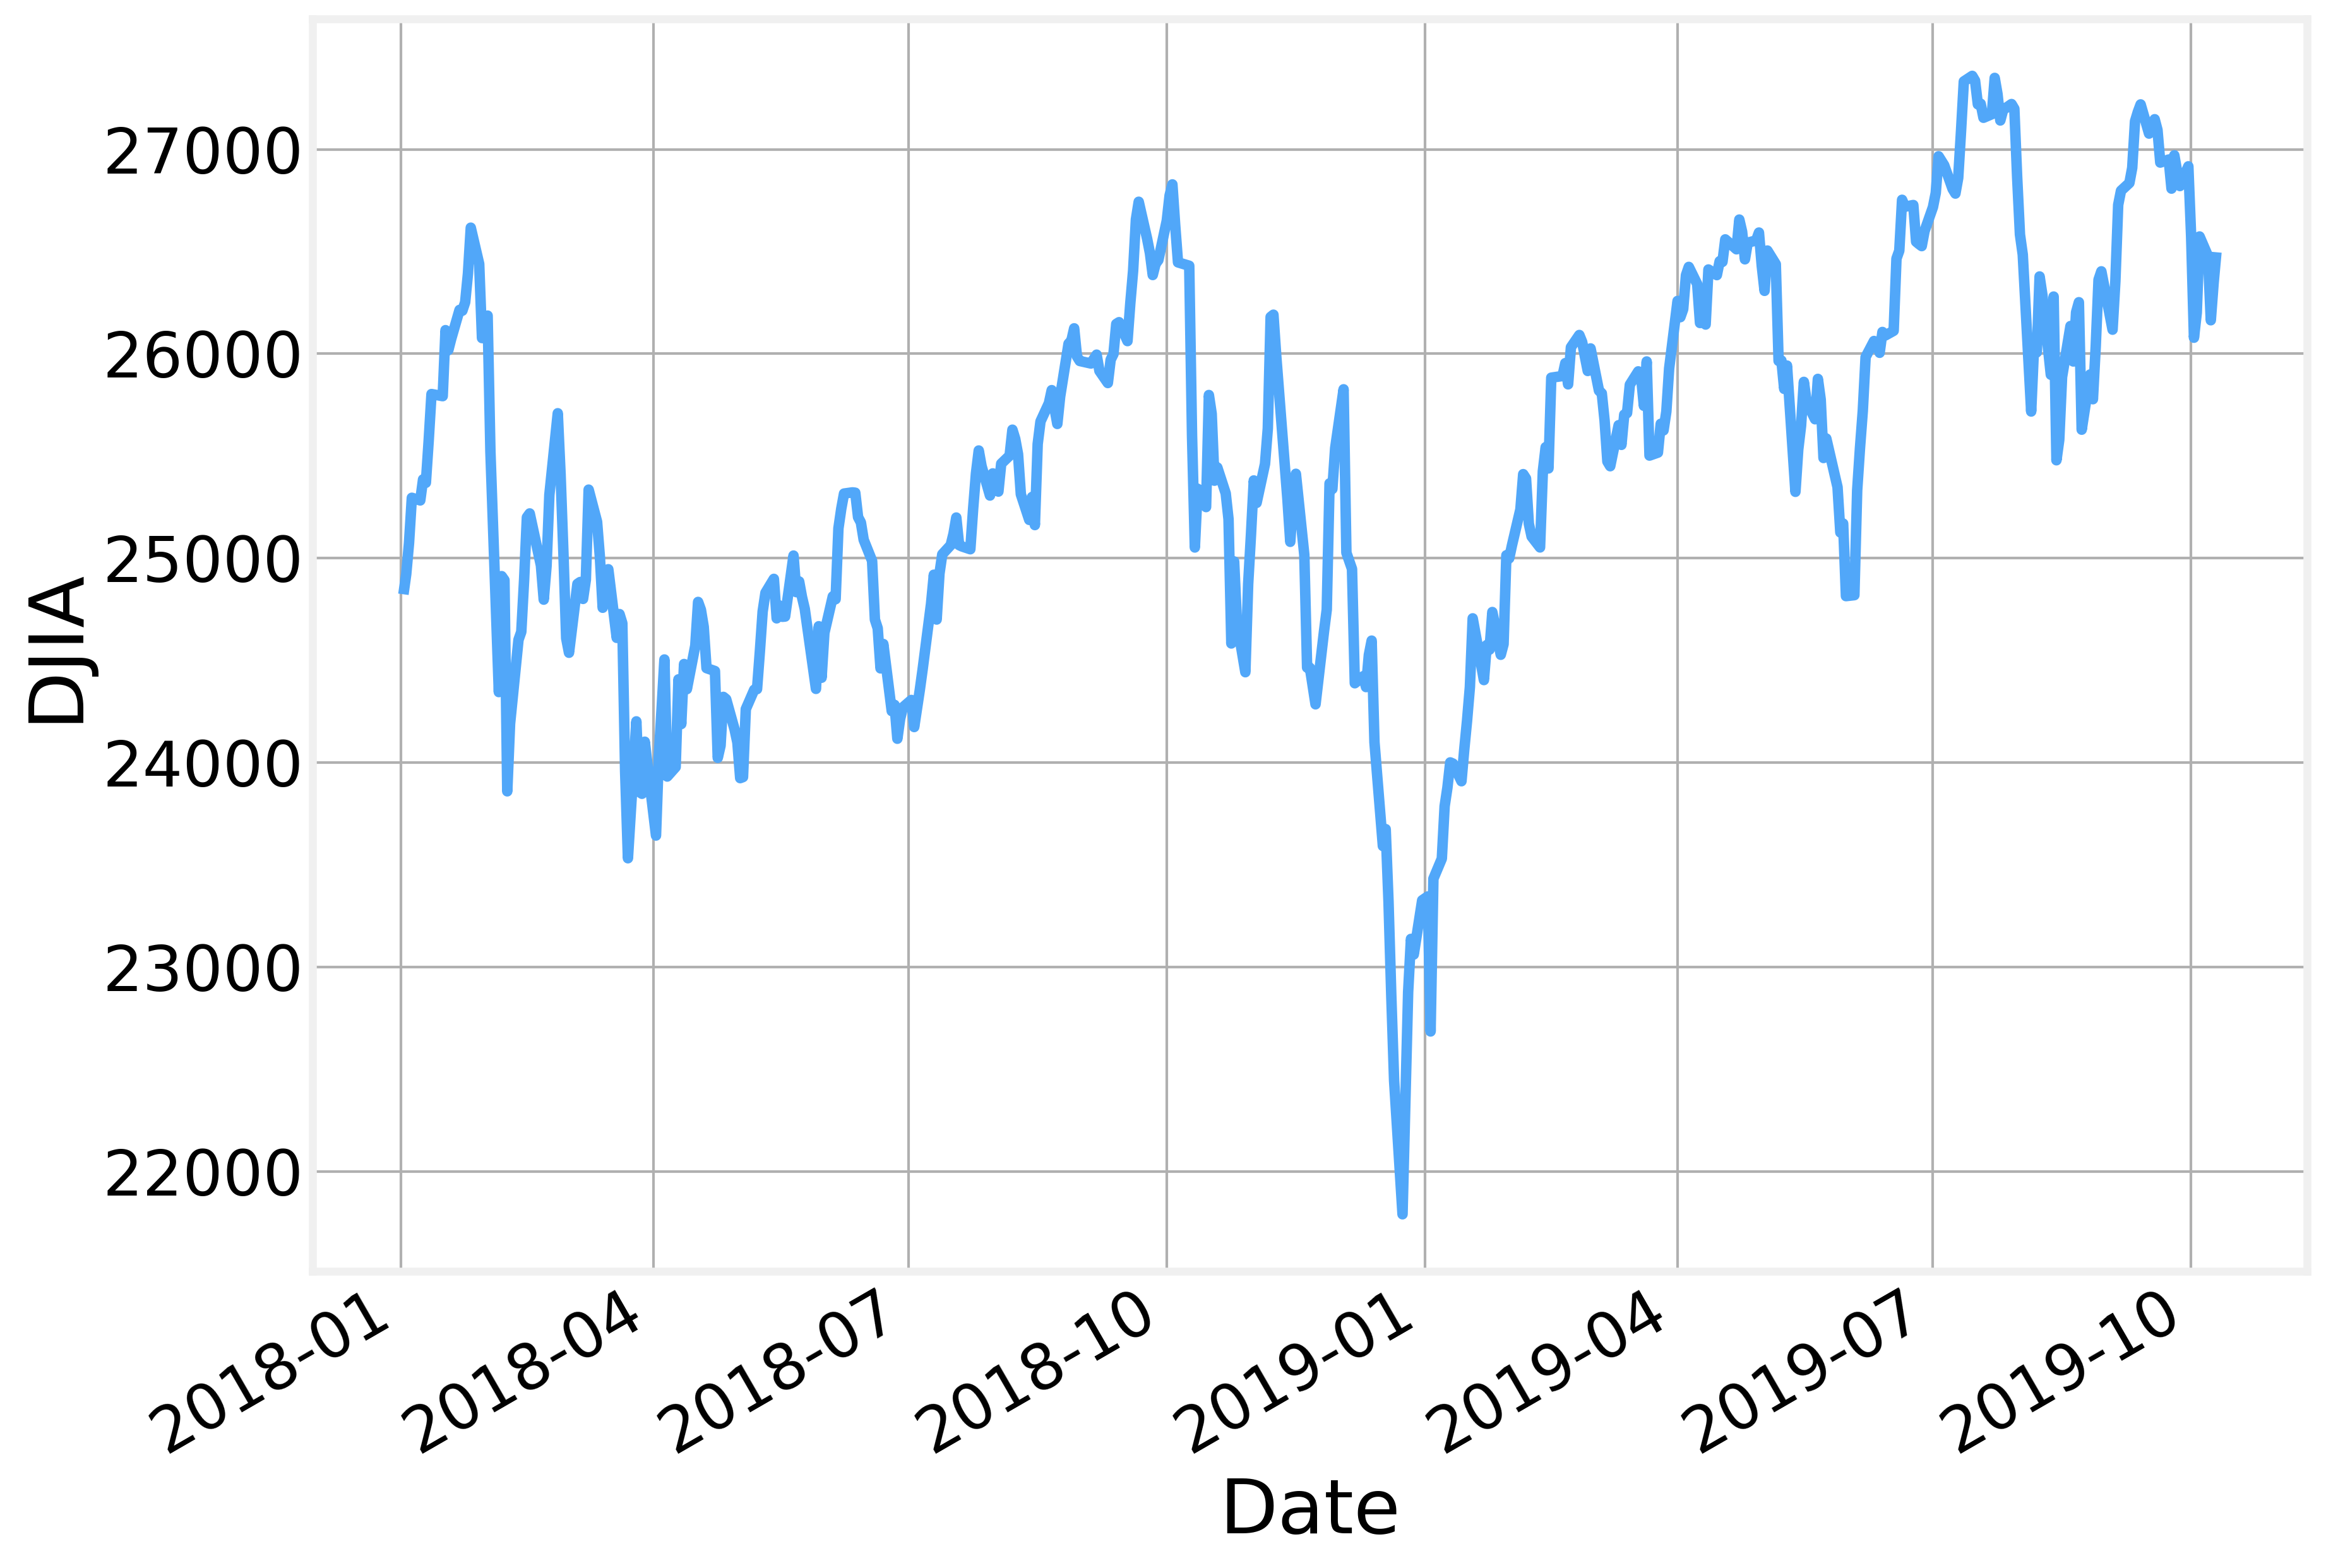

In [4]:
DJIA = pd.read_csv('data/DJIA.csv', parse_dates=['DATE'], na_values='.').dropna()
DJIA.set_index('DATE', inplace=True)

# Subset the time series
DJIA = DJIA['2018':].copy() 

ax = DJIA.plot(legend=False)
ax.set_ylabel('DJIA')
ax.set_xlabel('Date')

## Windowing

We also often want to calculate running values of some quantity. This requires the use of windowing functions that return the proper element at each step. 

In [5]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order+1):
        running.append(x[i:i+order])
        
    return np.array(running)

And a simple example

In [6]:
values = np.arange(11)

In [7]:
values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [8]:
rolling(values, 6)

array([[ 0,  1,  2,  3,  4,  5],
       [ 1,  2,  3,  4,  5,  6],
       [ 2,  3,  4,  5,  6,  7],
       [ 3,  4,  5,  6,  7,  8],
       [ 4,  5,  6,  7,  8,  9],
       [ 5,  6,  7,  8,  9, 10]])

Since we return a numpy array with all the individual windows, this also provides us with a simple way to take running averages by chaining methods

In [9]:
rolling(values, 2)

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10]])

In [10]:
rolling(values, 2).mean(axis=1)

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

Or the running maximum, etc.

In [11]:
rolling(values, 5).max(axis=1)

array([ 4,  5,  6,  7,  8,  9, 10])

Naturally, pandas already includes such a function as part of the DataFrames object, so to calculate a running mean of sizes 6, 30 and 60, we must only do:

In [12]:
DJIA['mean06'] = DJIA['DJIA'].rolling(6).mean()
DJIA['mean30'] = DJIA['DJIA'].rolling(30).mean()
DJIA['mean60'] = DJIA['DJIA'].rolling(60).mean()

And we can now plot them side by side

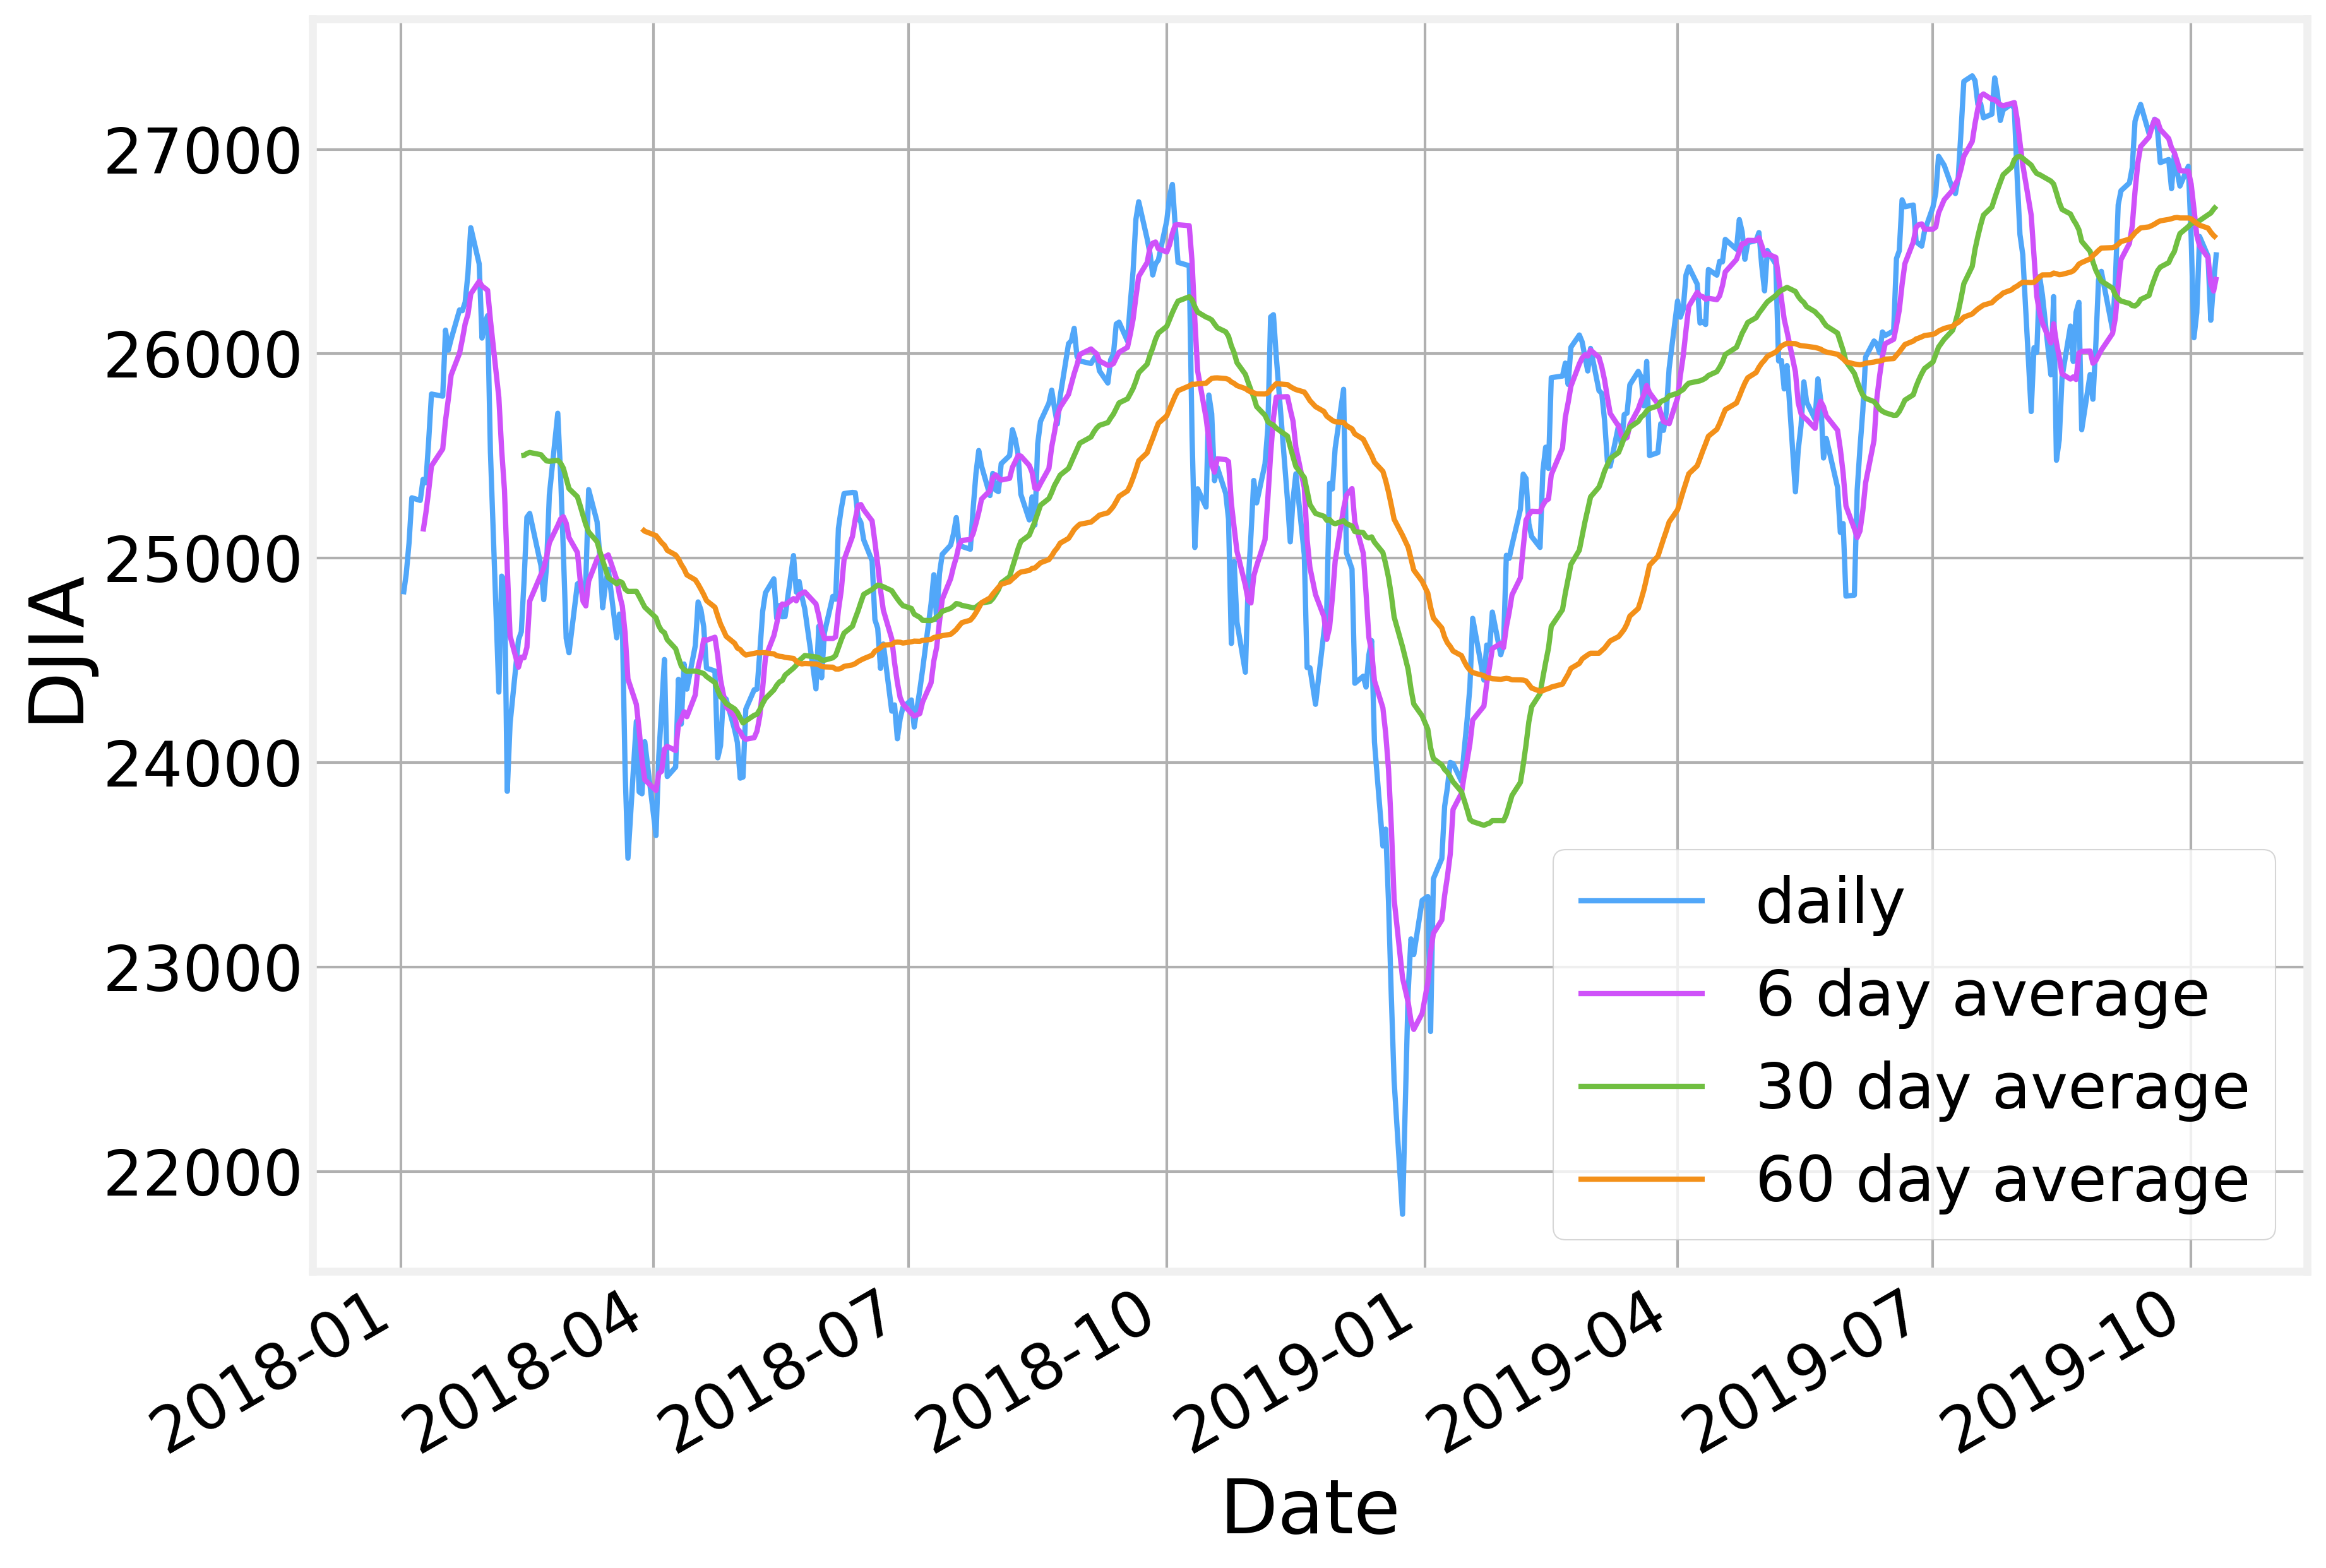

In [13]:
DJIA.plot(lw=2)
ax = plt.gca()
ax.set_ylabel('DJIA')
ax.set_xlabel('Date')
ax.legend(['daily', '6 day average', '30 day average', '60 day average'])

As we increase the size of the window, we naturally reduce the size of the fluctuations we allow to survive at the cost of losing some data points in the beginning of the series.

### Exercise

Calculate and plot the time series envelope using a running 30 day mean, max and min

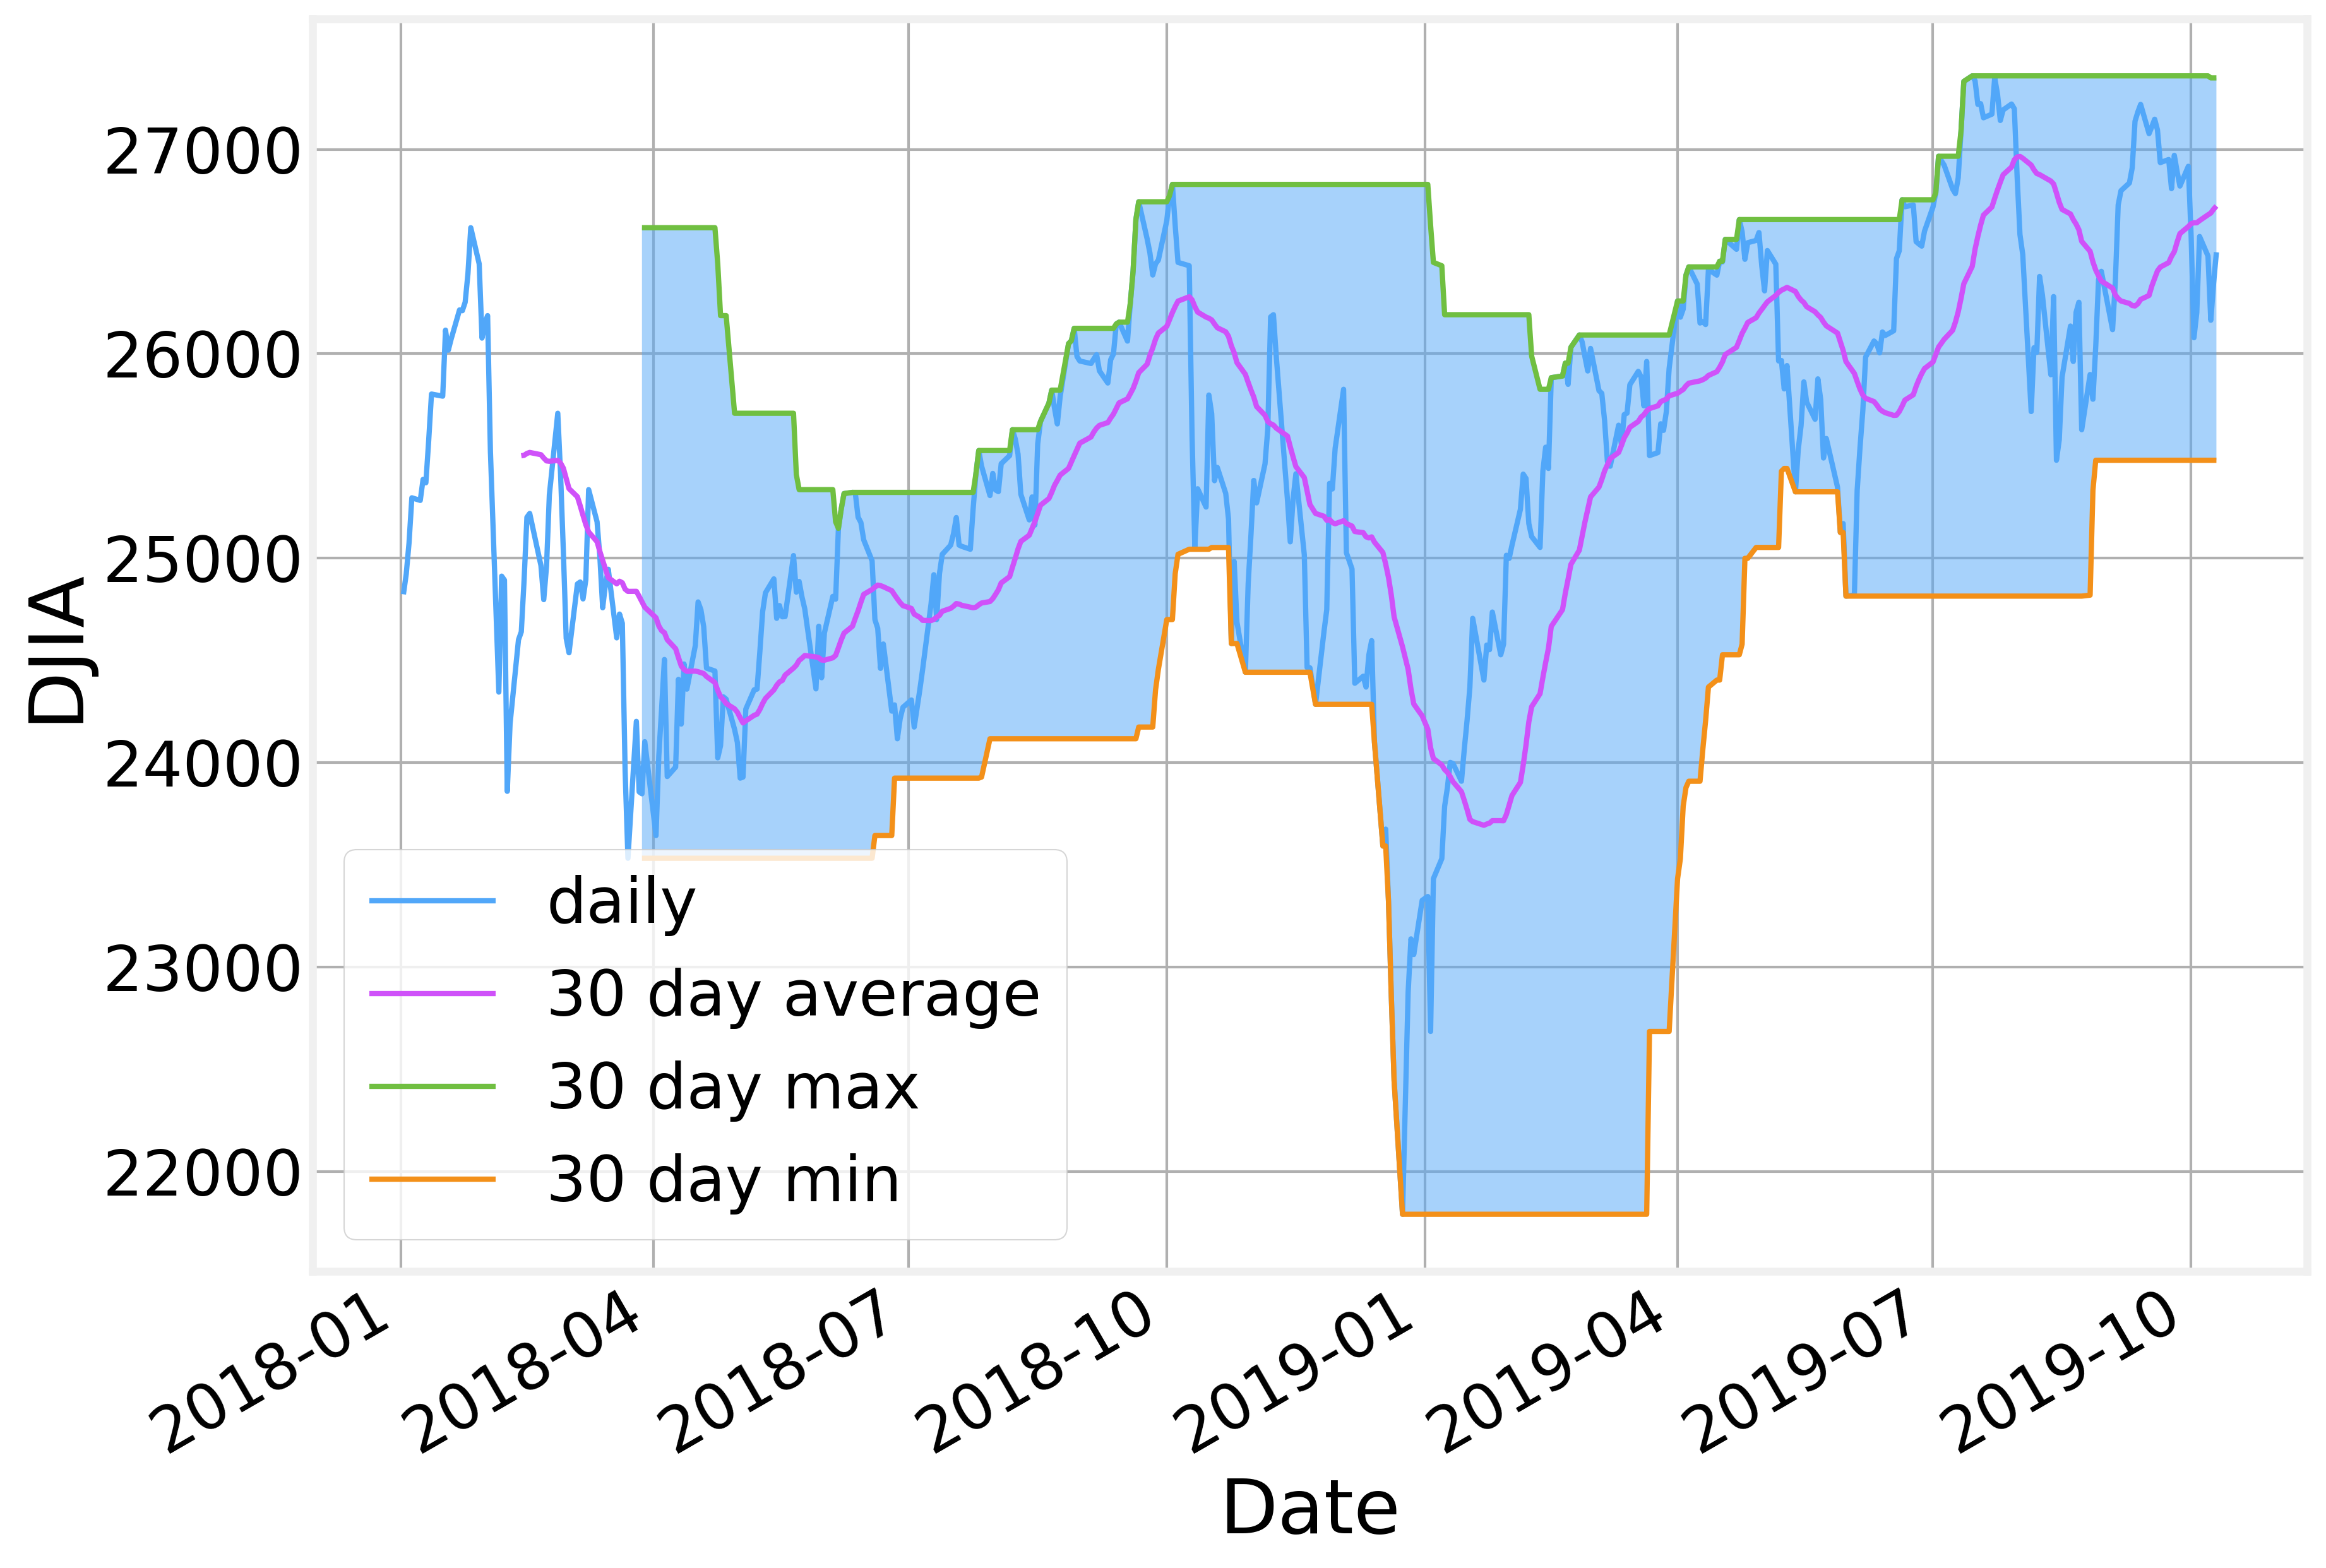

In [14]:
# %load solutions/DJIA_envelope.py
DJIA['mean30'] = DJIA['DJIA'].rolling(30).mean()
DJIA['max30'] = DJIA['DJIA'].rolling(60).max()
DJIA['min30'] = DJIA['DJIA'].rolling(60).min()

ax = DJIA[['DJIA', 'mean30', 'max30', 'min30']].plot(lw=2)
ax.fill_between(x=DJIA.index, y1=DJIA['max30'].values, y2=DJIA['min30'].values, alpha=0.5)

ax.set_ylabel('DJIA')
ax.set_xlabel('Date')
ax.legend(['daily', '30 day average', '30 day max', '30 day min'], loc='lower left')

## Bands

And by calculating different metrics, we can evaluate some more sophisticated metrics. For example, the [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) of a time series are defined as the moving average of size $N$ and the envelope defined by $K$ times the moving standard deviation.

In [15]:
N = 20
K = 2

DJIA['BBMA'] = DJIA['DJIA'].rolling(30).mean()
DJIA['BBUp'] = DJIA['BBMA'] + K*DJIA['DJIA'].rolling(30).std()
DJIA['BBDown'] = DJIA['BBMA'] - K*DJIA['DJIA'].rolling(30).std()

As we can see, this neatly deliniates the range of likely values 

Text(0, 0.5, 'DJIA')

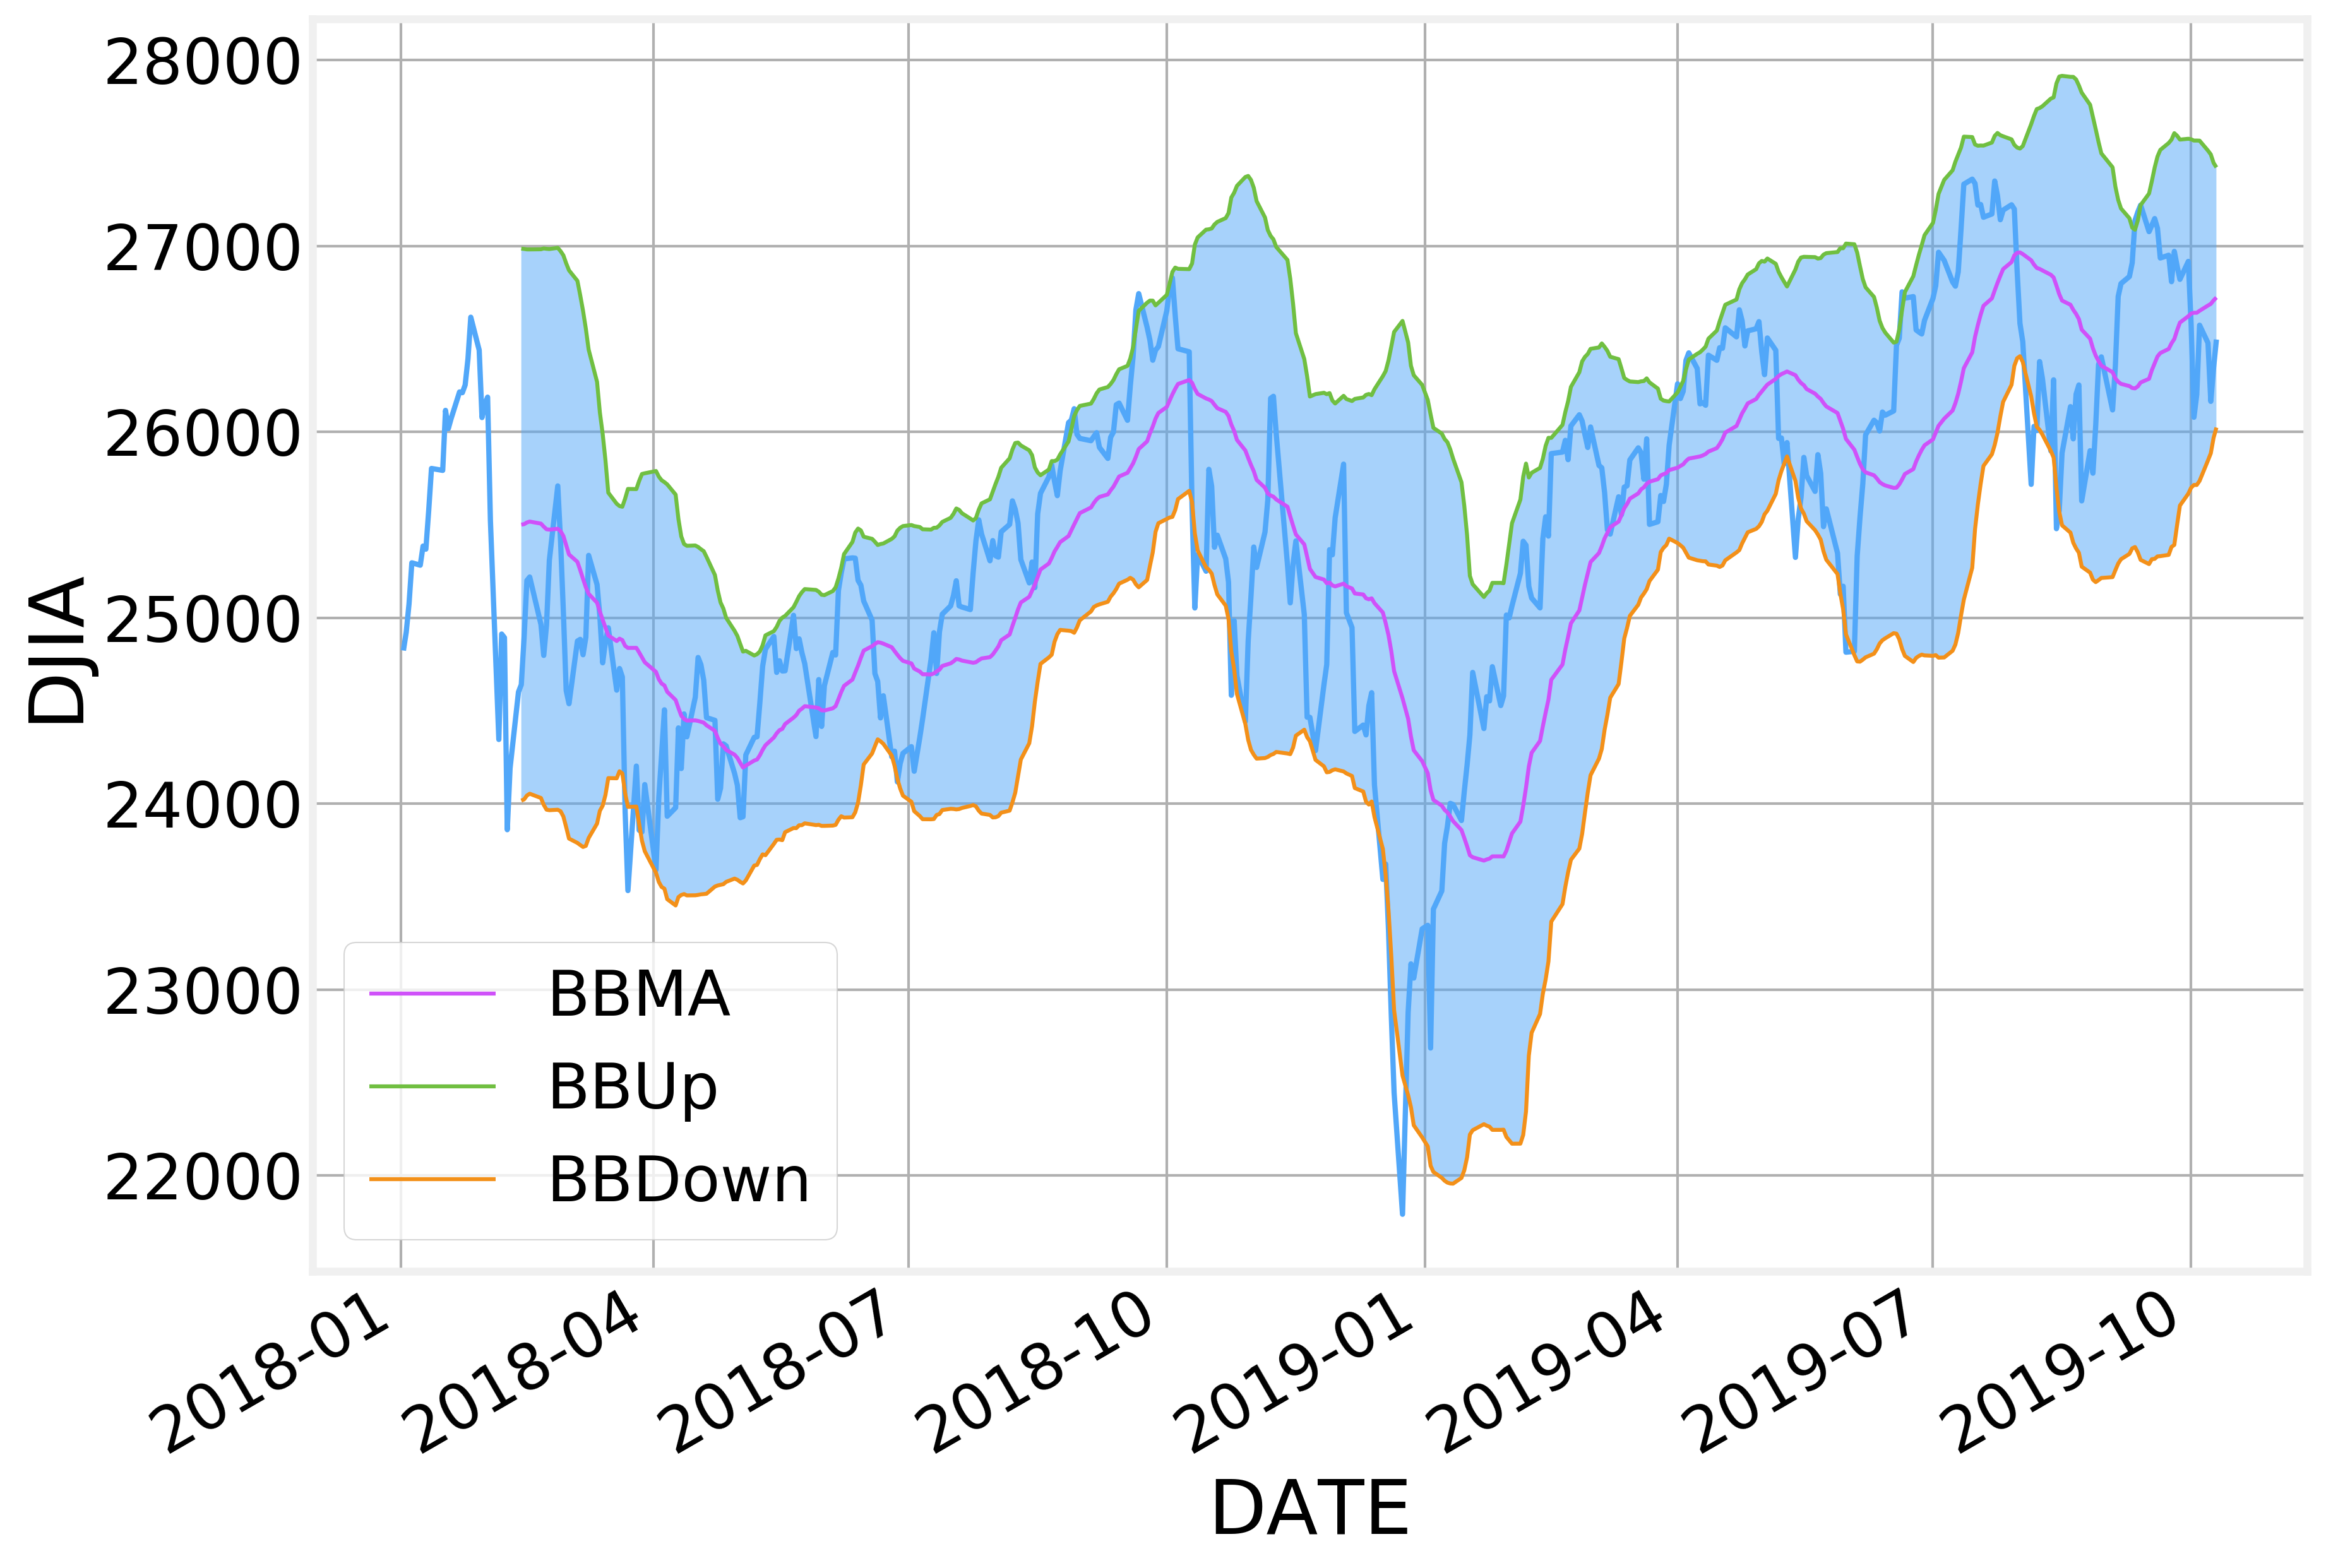

In [16]:
ax = DJIA.plot(y=['DJIA'], lw=2, legend=False)
ax.fill_between(x=DJIA.index, y1=DJIA['BBUp'].values, y2=DJIA['BBDown'].values, alpha=0.5)
DJIA.plot(y=['BBMA', 'BBUp', 'BBDown'], lw=1.5, ax=ax)
ax.set_ylabel('DJIA')

Any points where the true values go over the upper or lower Bollinger Band indicates a point where the characteristics of the time series is differnet than expected and we might want to take a closer look. The DJIA crossed the lower Bollinger Bands defined above in 25 different occasions since 2018:

In [17]:
crosses = DJIA[DJIA['DJIA'] < DJIA['BBDown']][['DJIA', 'BBDown']]

Naturally, these tend to cluster together in time.

Text(0, 0.5, 'DJIA')

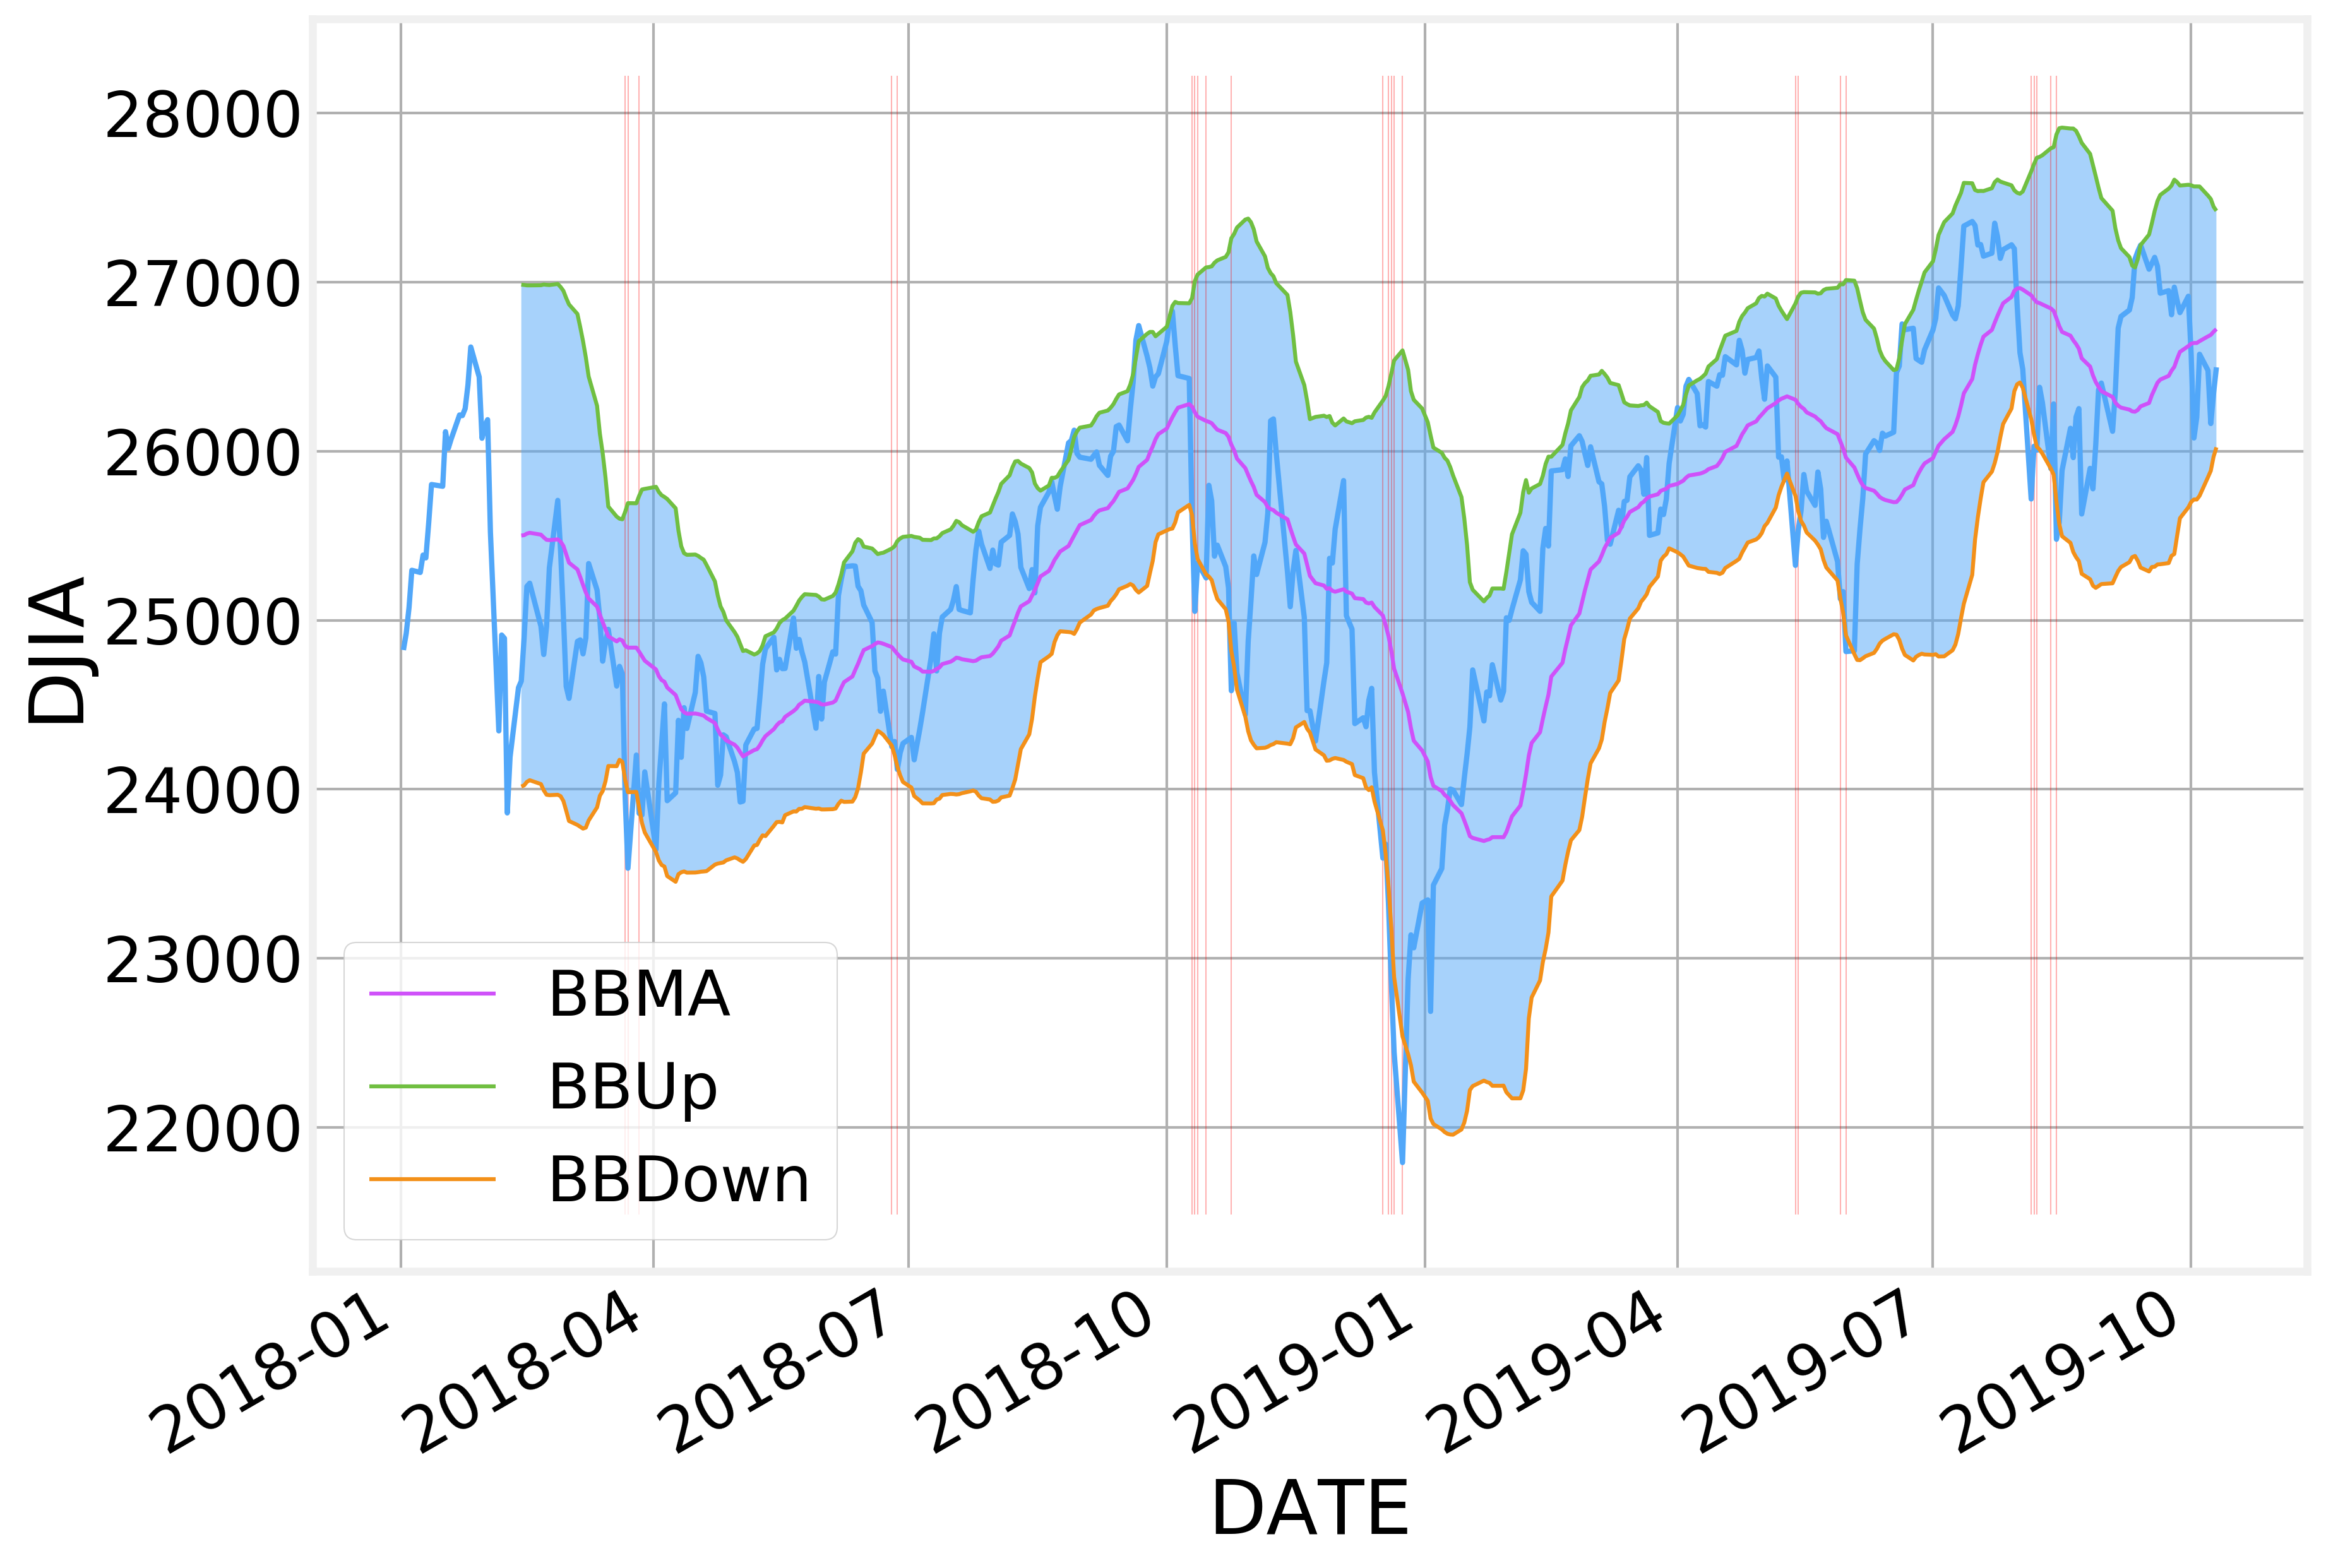

In [18]:
ax = DJIA.plot(y=['DJIA'], lw=2, legend=False)
DJIA.plot(y=['BBMA', 'BBUp', 'BBDown'], lw=1.5, ax=ax)
ax.fill_between(x=DJIA.index, y1=DJIA['BBUp'].values, y2=DJIA['BBDown'].values, alpha=0.5)

ymin, ymax = ax.get_ylim()
ax.vlines(x=crosses.index, ymax=ymax, ymin=ymin, colors='r', lw=0.5, alpha=0.3)
ax.set_ylabel('DJIA')

This kind of simple analysis can allow traders to identify buy/sell opportunities

## Exponential Running averages

In the case of the simple moving averages we considered above, we are giving each point the same weight, irregardless of how far back in the past it corresponds to. Another approach is to weight each point that contributes to a moving average in such a way that the older the point the more strongly it gets discounted. See [this paper](https://www.researchgate.net/profile/Marcus_Perry/publication/313992620_The_Exponentially_Weighted_Moving_Average/links/59e8adcfaca272bc4240bcd3/The-Exponentially-Weighted-Moving-Average.pdf?origin=publication_detail) for a more detailed discussion.

In [19]:
def EWMA(values, alpha=0.01):
    N = len(values)
    S = [values[0]]
    
    for i in range(1, N):
        S.append(alpha*values[i]+(1-alpha)*S[-1])
        
    return np.array(S)

As we can see with a few quick examples, the smaller the value of alpha the smoother (less noisy) the result

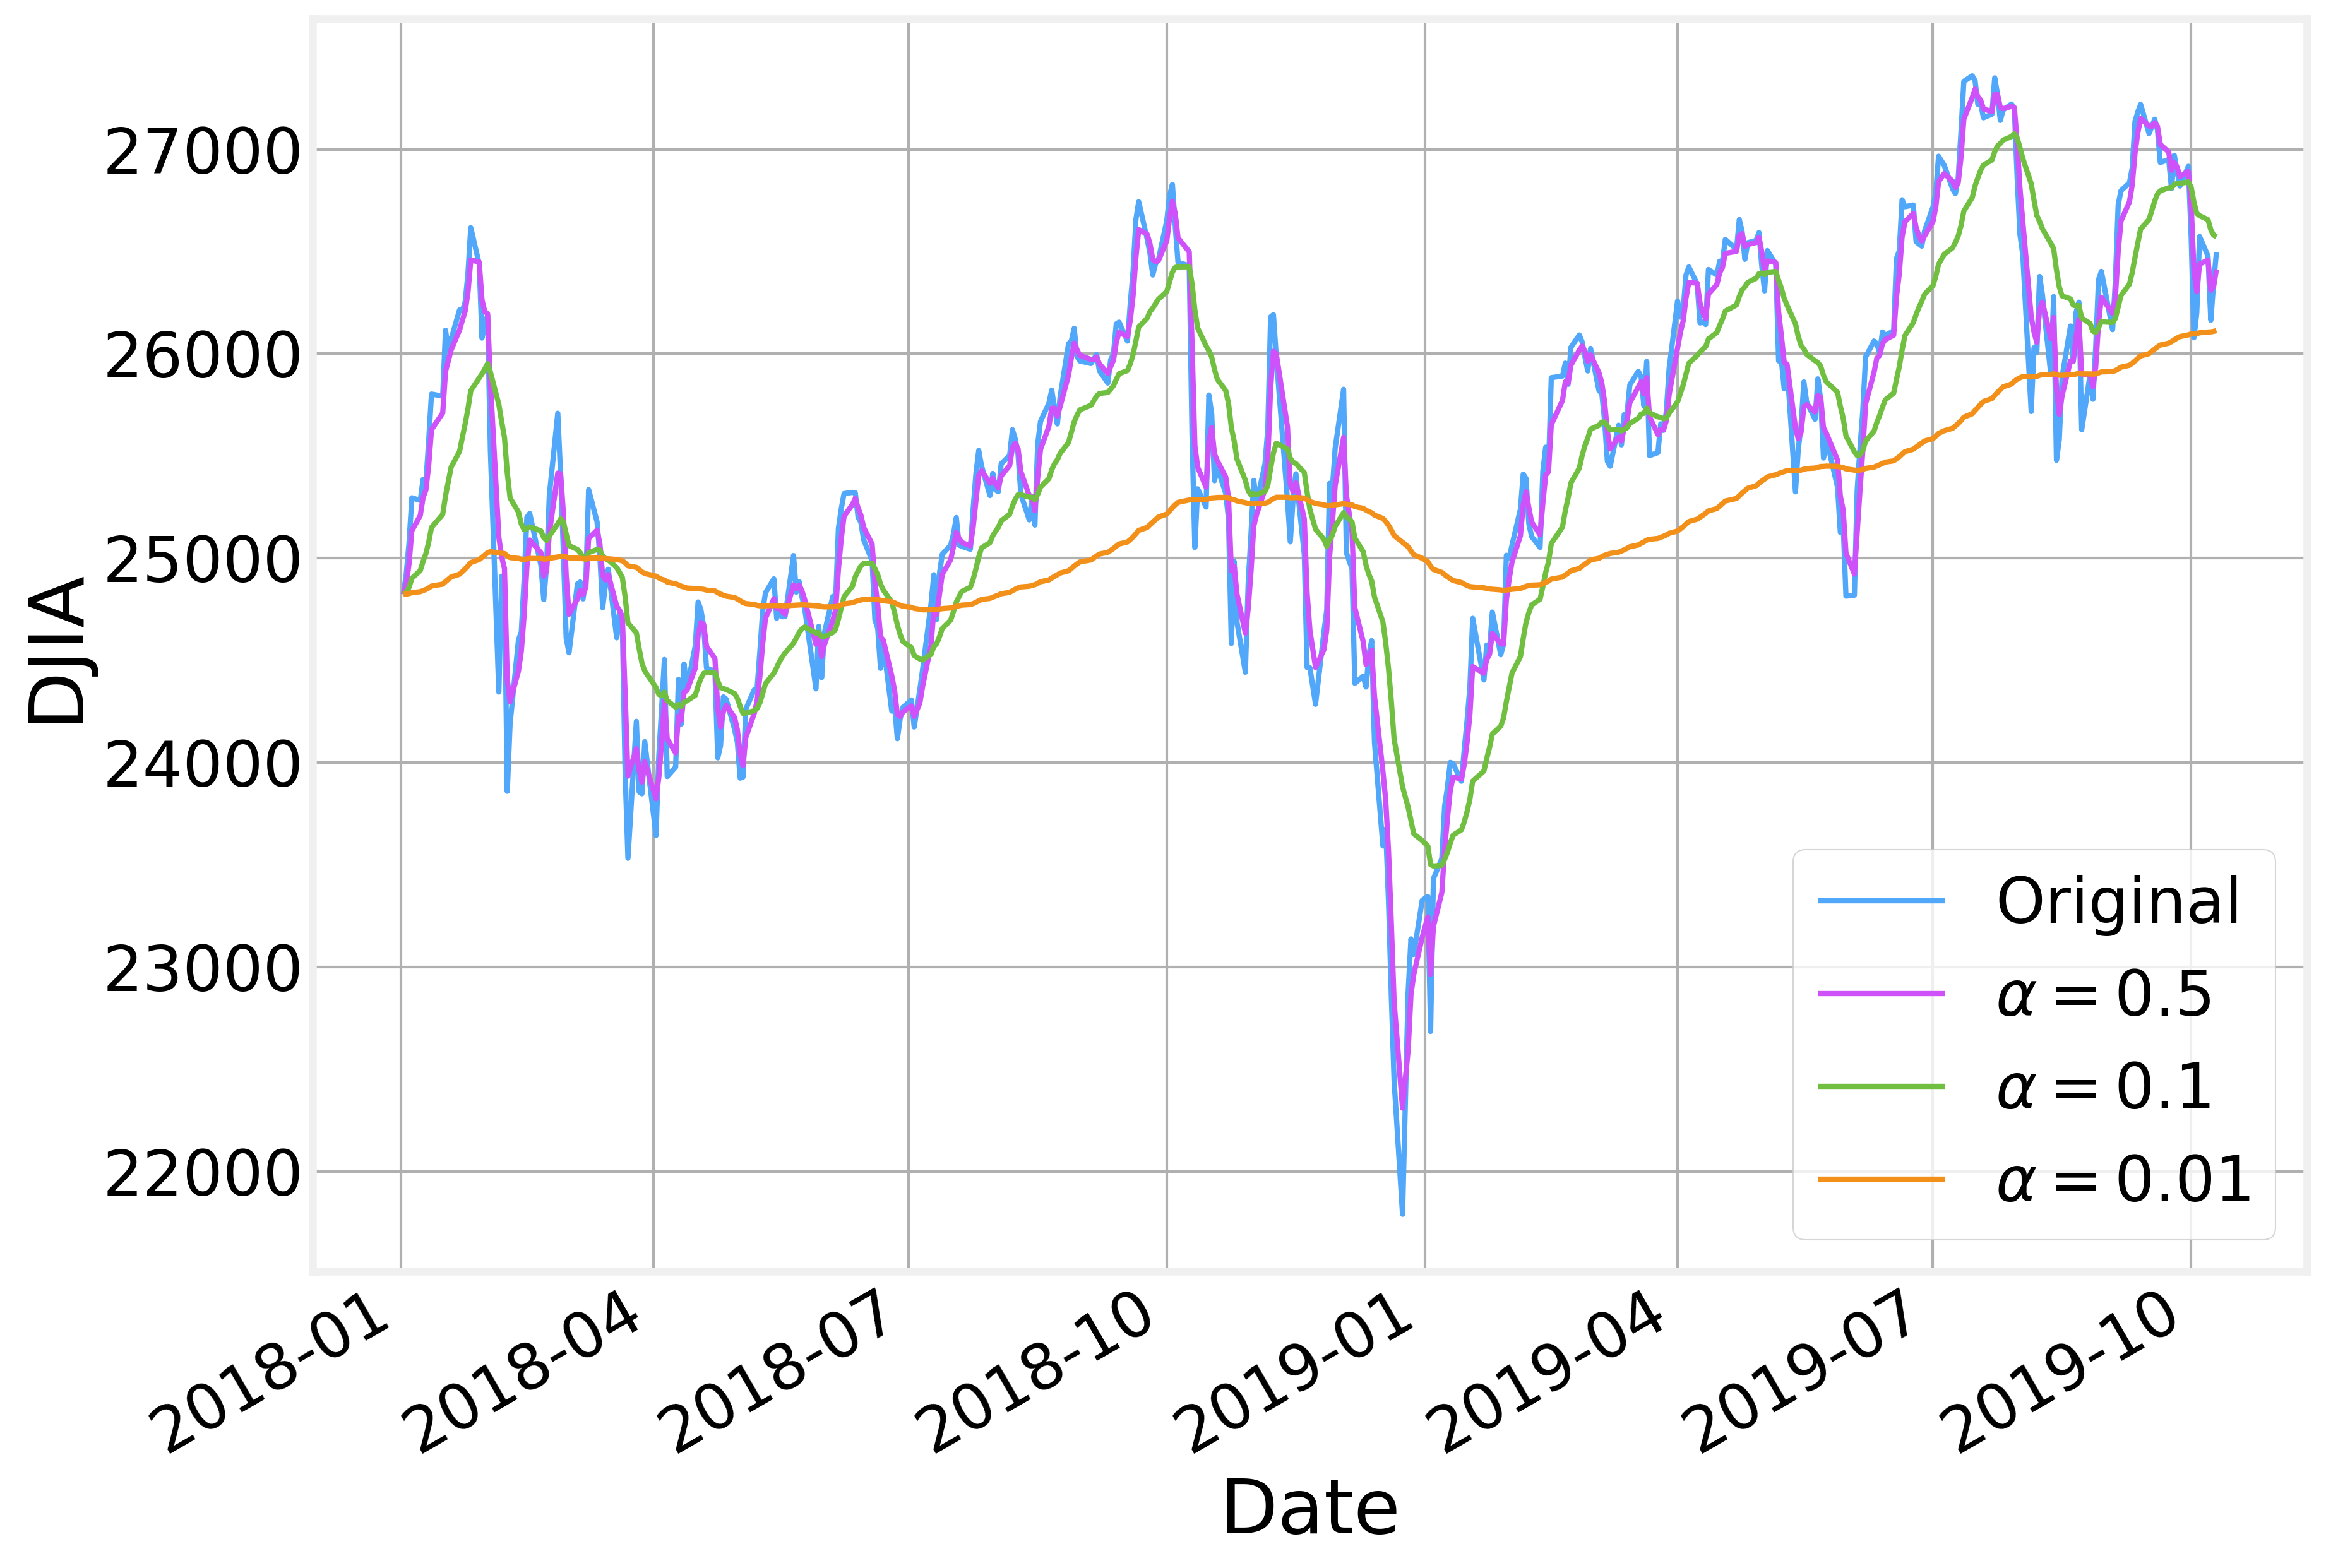

In [20]:
ax = DJIA['DJIA'].plot(label='Original', lw=2)
ax.plot(DJIA.index, EWMA(DJIA['DJIA'], 0.5),  label=r'$\alpha=0.5$',  lw=2)
ax.plot(DJIA.index, EWMA(DJIA['DJIA'], 0.1),  label=r'$\alpha=0.1$',  lw=2)
ax.plot(DJIA.index, EWMA(DJIA['DJIA'], 0.01), label=r'$\alpha=0.01$', lw=2)
ax.set_xlabel('Date')
ax.set_ylabel('DJIA')
ax.legend()

While for $\alpha\equiv 1$ we recover the original values, as expected

In [21]:
(EWMA(DJIA['DJIA'], 1)-DJIA['DJIA']).mean()

0.0

Pandas provides the __ewm__ method https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html that simplifies our life

Text(0, 0.5, 'DJIA')

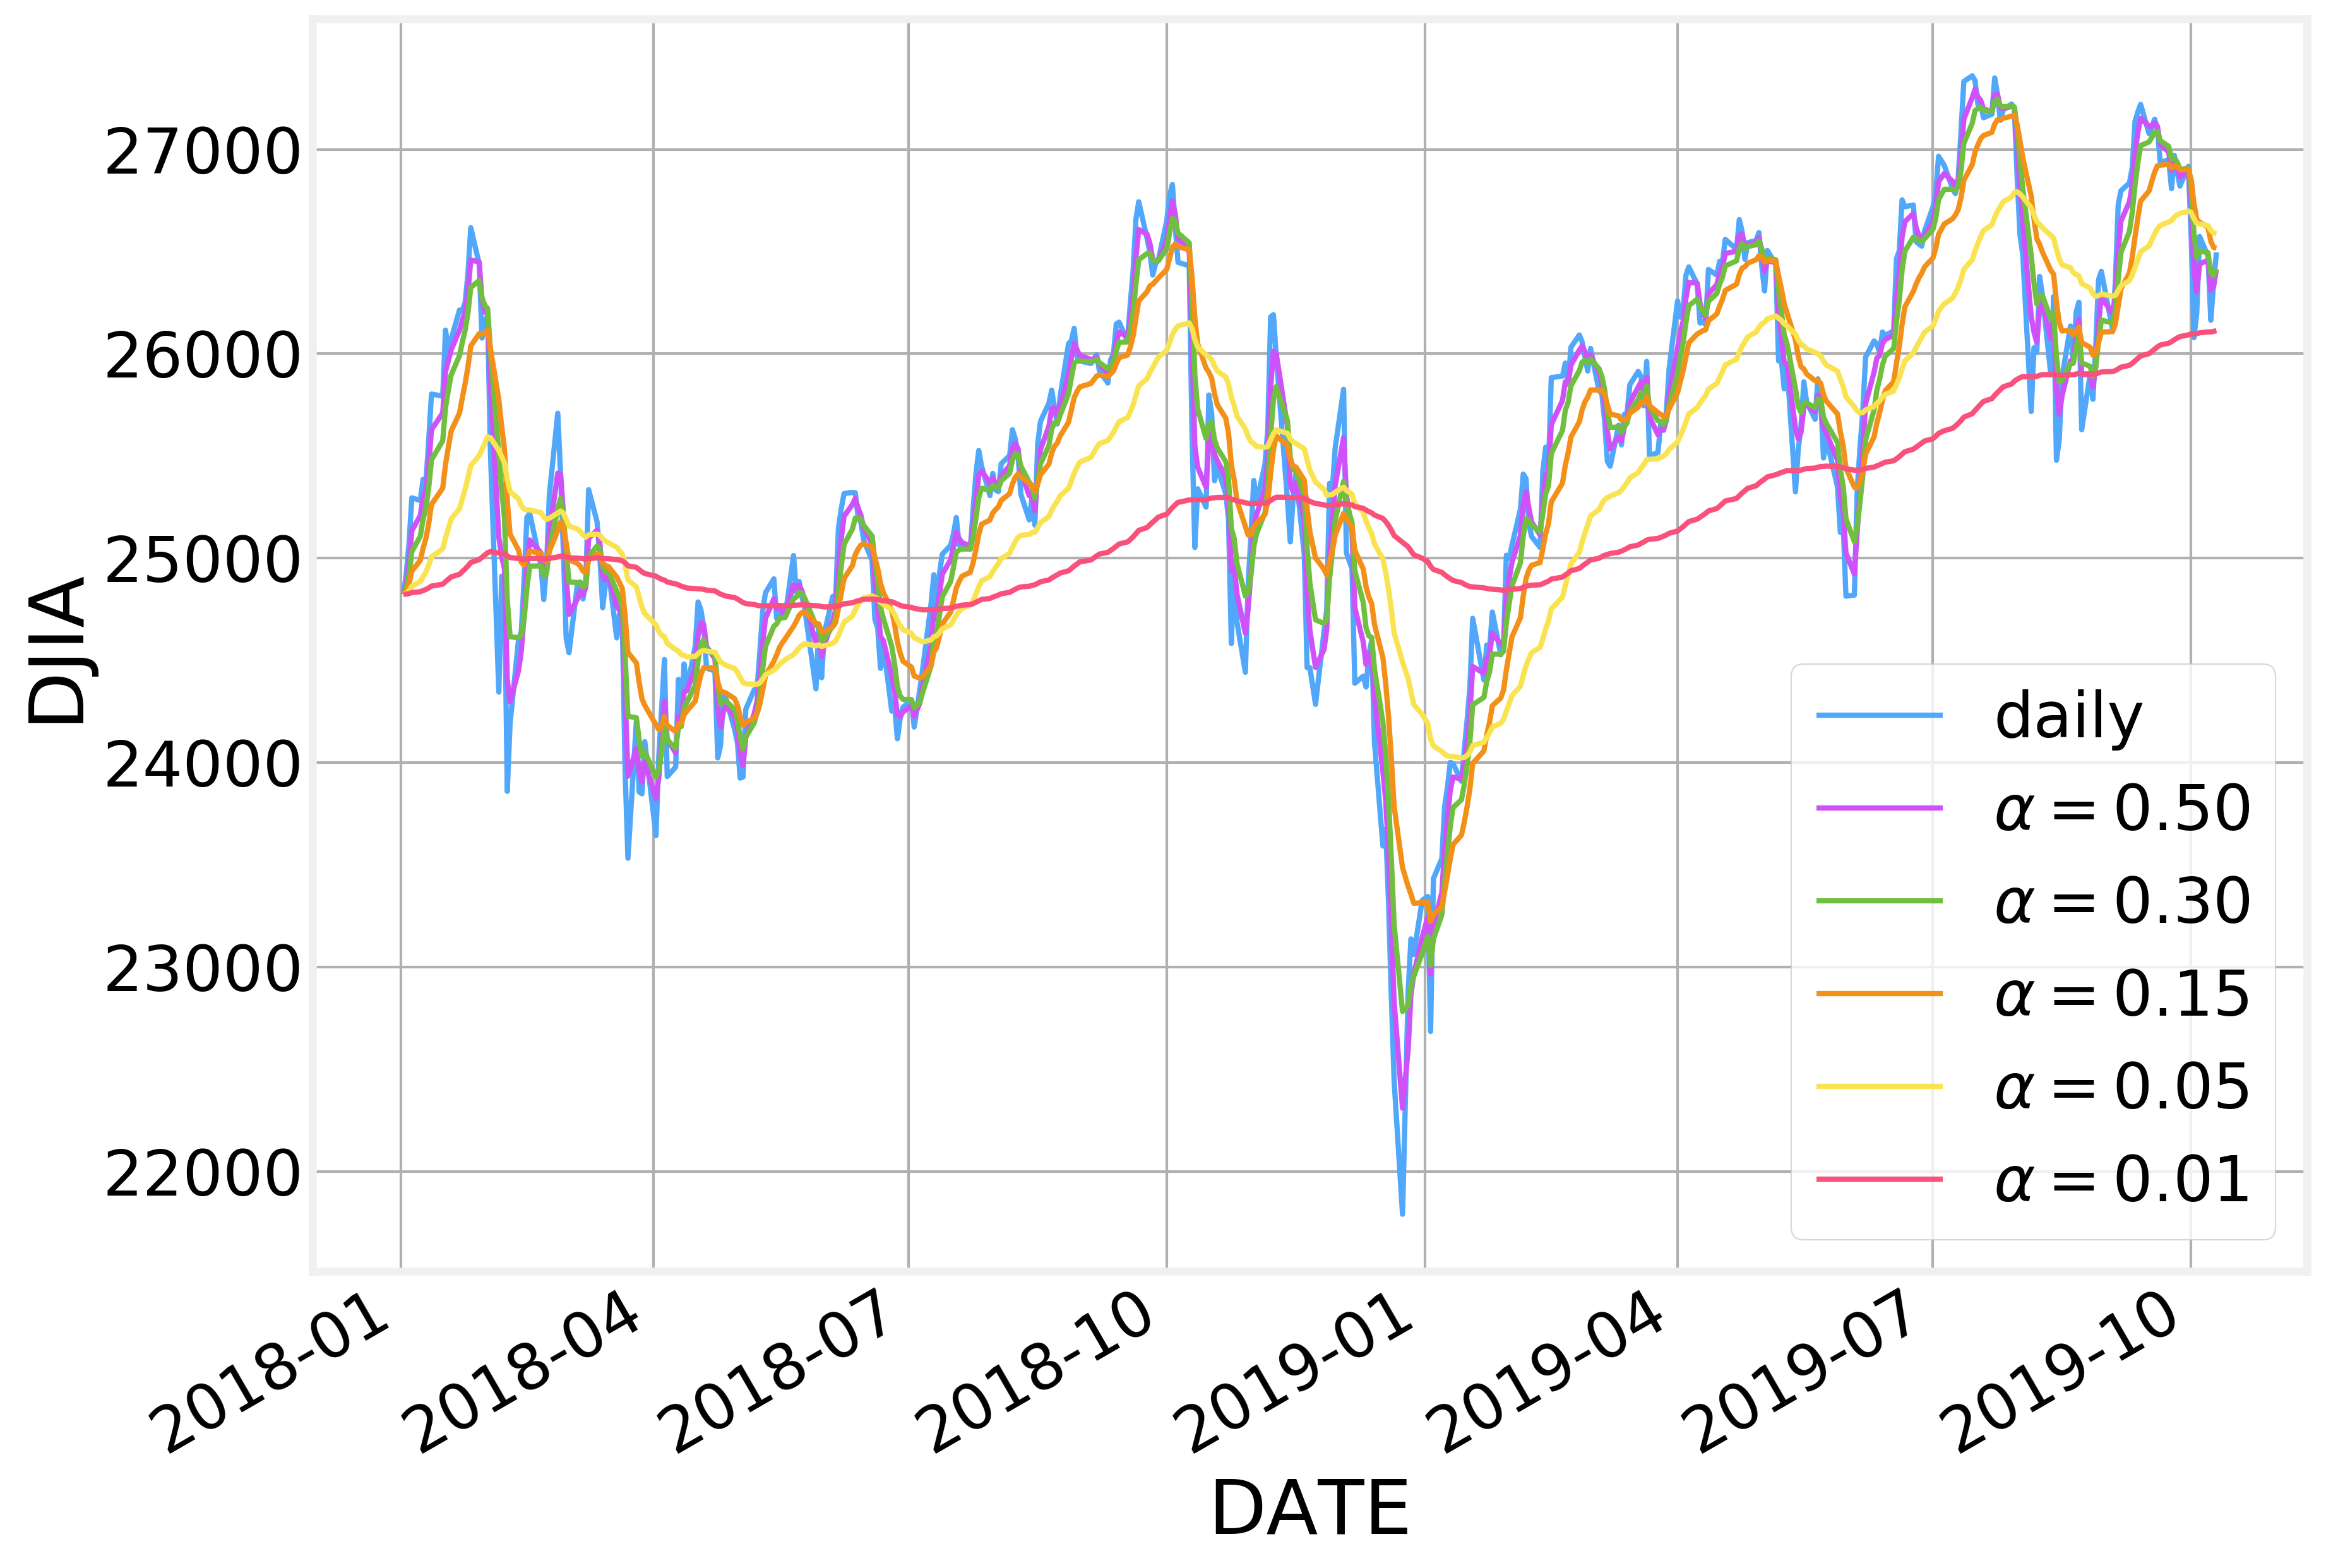

In [22]:
DJIA['alpha50'] = DJIA['DJIA'].ewm(alpha=0.50, adjust=False).mean()
DJIA['alpha30'] = DJIA['DJIA'].ewm(alpha=0.30, adjust=False).mean()
DJIA['alpha15'] = DJIA['DJIA'].ewm(alpha=0.15, adjust=False).mean()
DJIA['alpha05'] = DJIA['DJIA'].ewm(alpha=0.05, adjust=False).mean()
DJIA['alpha01'] = DJIA['DJIA'].ewm(alpha=0.01, adjust=False).mean()

ax = DJIA.plot(y=['DJIA', 'alpha50', 'alpha30', 'alpha15', 'alpha05', 'alpha01'], lw=2)
ax.legend(['daily', r'$\alpha=0.50$', r'$\alpha=0.30$', r'$\alpha=0.15$', r'$\alpha=0.05$', r'$\alpha=0.01$'])
ax.set_ylabel('DJIA')

Which produces the exact same results as our hand crafted function above:

In [23]:
np.mean(EWMA(DJIA['DJIA'], 0.5)-DJIA['DJIA'].ewm(alpha=0.50, adjust=False).mean())

0.0

The difference between __adjust=True__ and __adjust=False__ is only noticeable in the first few steps and are related to different assumptions about the first point in the series

Text(0, 0.5, 'Difference')

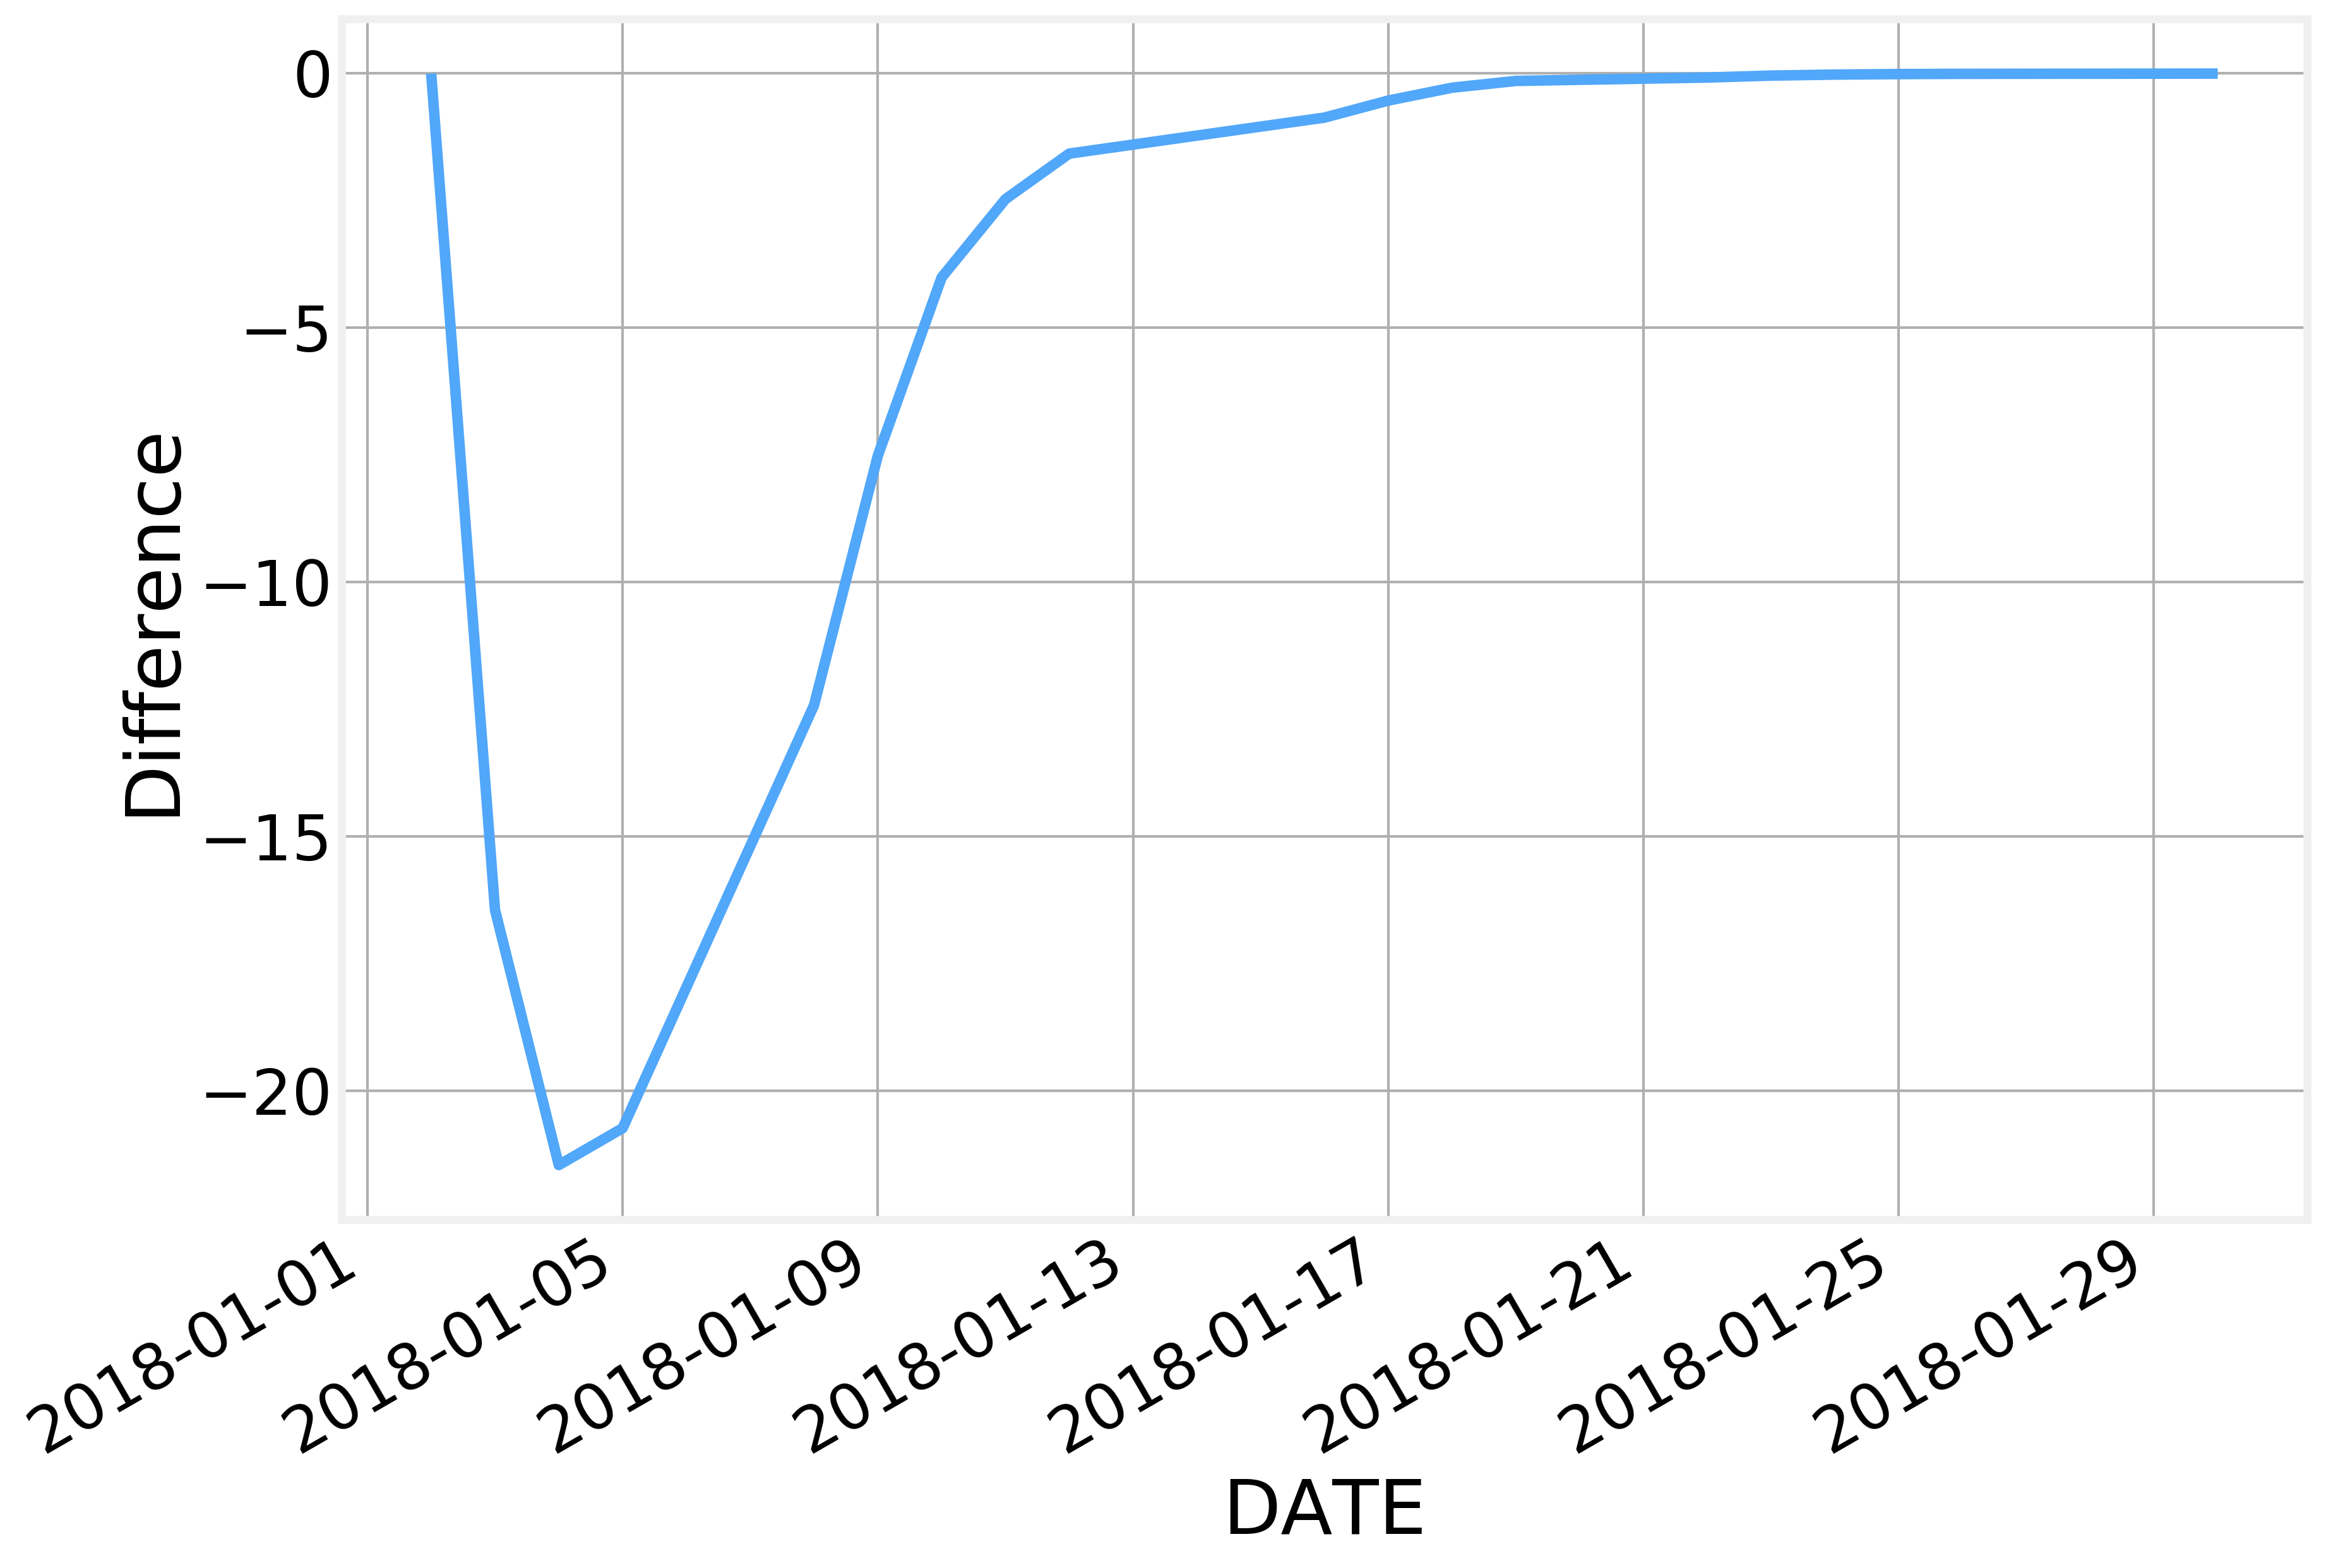

In [24]:
ax = (DJIA['DJIA'].ewm(alpha=0.50, adjust=False).mean()-DJIA['DJIA'].ewm(alpha=0.50, adjust=True).mean())[:20].plot()
ax.set_ylabel('Difference')

In addition to this difference, __ewa__ also provides significantly more functionality:

- __mean()__ - EW moving average
- __var()__ - EW moving variance
- __std()__ - EW moving standard deviation
- __corr()__ - EW moving correlation
- __cov()__ - EW moving covariance

See https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows for the complete documentation

## Forecasting

We can also use the exponentially weighted moving average as a (simple) way of forecasting new values of our time series. In the absence of any other information, we can expect the value at $t+1$, say $z_{t+1}$, to simply be the EWMA value of up to that point. In other words:

$$z_{t+1}=\alpha x_t+\left(1-\alpha\right)z_t$$

where $x_t$ is the true value at $t$ and $z_t$ the EMWA at that point. We can rewrite this as

$$z_{t+1}=z_{t}+\alpha\left(x_t-z_t\right)$$

which shows clearly how the "forecasted" value at $t+1$ is simply the EWMA value at $t$ plus the scaled error between $x_t$ and $z_t$. If we then add $z_{t+1}$ to the time series, then we can repeat the process when we get a new point.

In [25]:
def ewma_forecast(value, ewm, alpha):
    return alpha*value+(1-alpha)*ewm

In [26]:
def forecast(values, alpha, N):
    ewma = values.ewm(alpha=alpha, adjust=False).mean()
    
    new_values = []
    
    for i in range(N, values.shape[0]):
        # THe forecast at t can only use values at t-1
        new_values.append(ewma_forecast(values.iloc[i-1], ewma.iloc[i-1], alpha))
        
    return new_values

Now we can move along the timeseries and update our forecast for each new point and for a specific value of $\alpha$

In [27]:
N=400

forecast03 = forecast(DJIA['DJIA'], 0.3, N)
forecast05 = forecast(DJIA['DJIA'], 0.5, N)
forecast07 = forecast(DJIA['DJIA'], 0.7, N)

For clarity, we are skipping the first 400 points and forecasting only on the remaining periods. The changes as a function of $\alpha$ are not monotonic, with some values doing a better job in some periods than others:

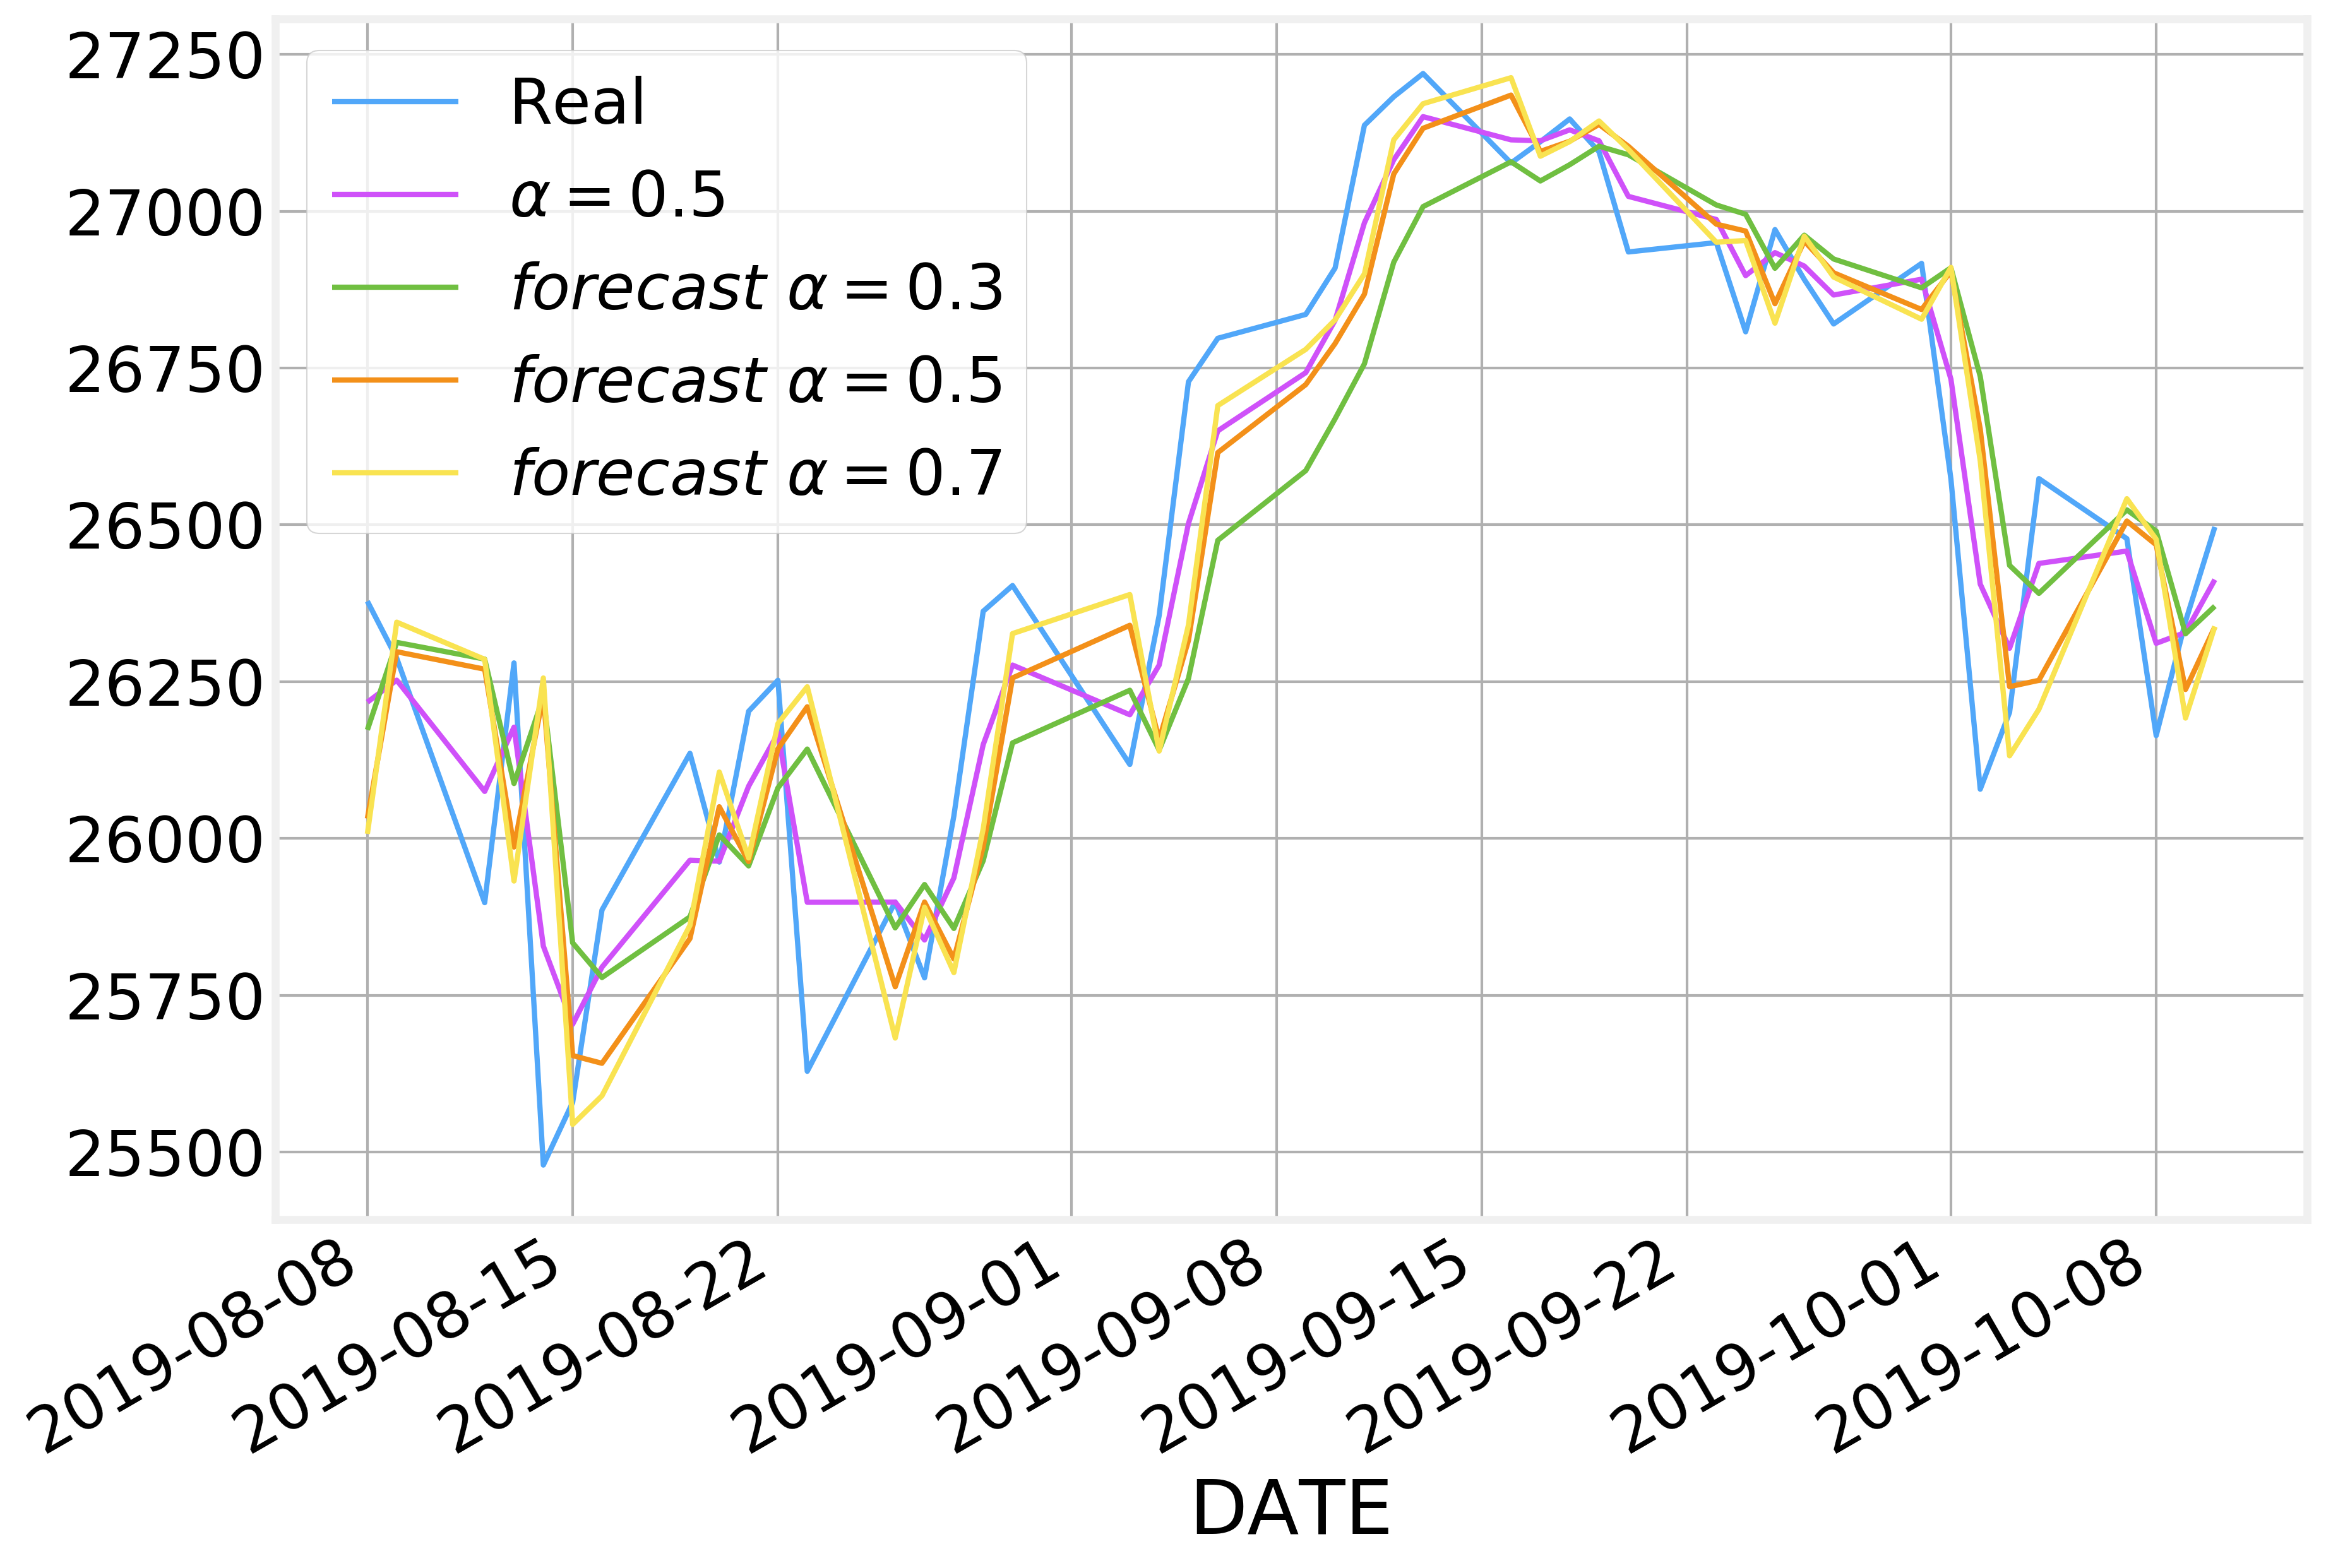

In [28]:
ax = DJIA.iloc[N:].plot(y=['DJIA'], lw=2)
DJIA.iloc[N:].plot(y=['alpha50'], lw=2, ax=ax)

ax.plot(DJIA.index[N:], forecast03, lw=2)
ax.plot(DJIA.index[N:], forecast05, lw=2)
ax.plot(DJIA.index[N:], forecast07, lw=2)

ax.legend(['Real', r'$\alpha=0.5$', r'$forecast~\alpha=0.3$', r'$forecast~\alpha=0.5$', r'$forecast~\alpha=0.7$'])

## Choice of $\alpha$

As we saw, the chocice of $\alpha$ has a direct impact on how smooth our timeseries becomes. But how can we choose the **right** value of $\alpha$? We start by quantifying the difference between the original time series and the Exponentially Smoothed version

In [29]:
def RMSE(values, ewm_values):
    error = np.sqrt(np.power(values - ewm_values, 2.0).mean())
    return error

And we calculate the value of the error for different values of $\alpha$.

In [30]:
err = []
alphas = np.linspace(0.01, 1, 100)
for alpha in alphas:
    err.append(RMSE(DJIA['DJIA'].iloc[N:], forecast(DJIA['DJIA'], alpha, N)))

Surprisingly, we find that the error doesn't continuously improve as we increase the value of $\alpha$

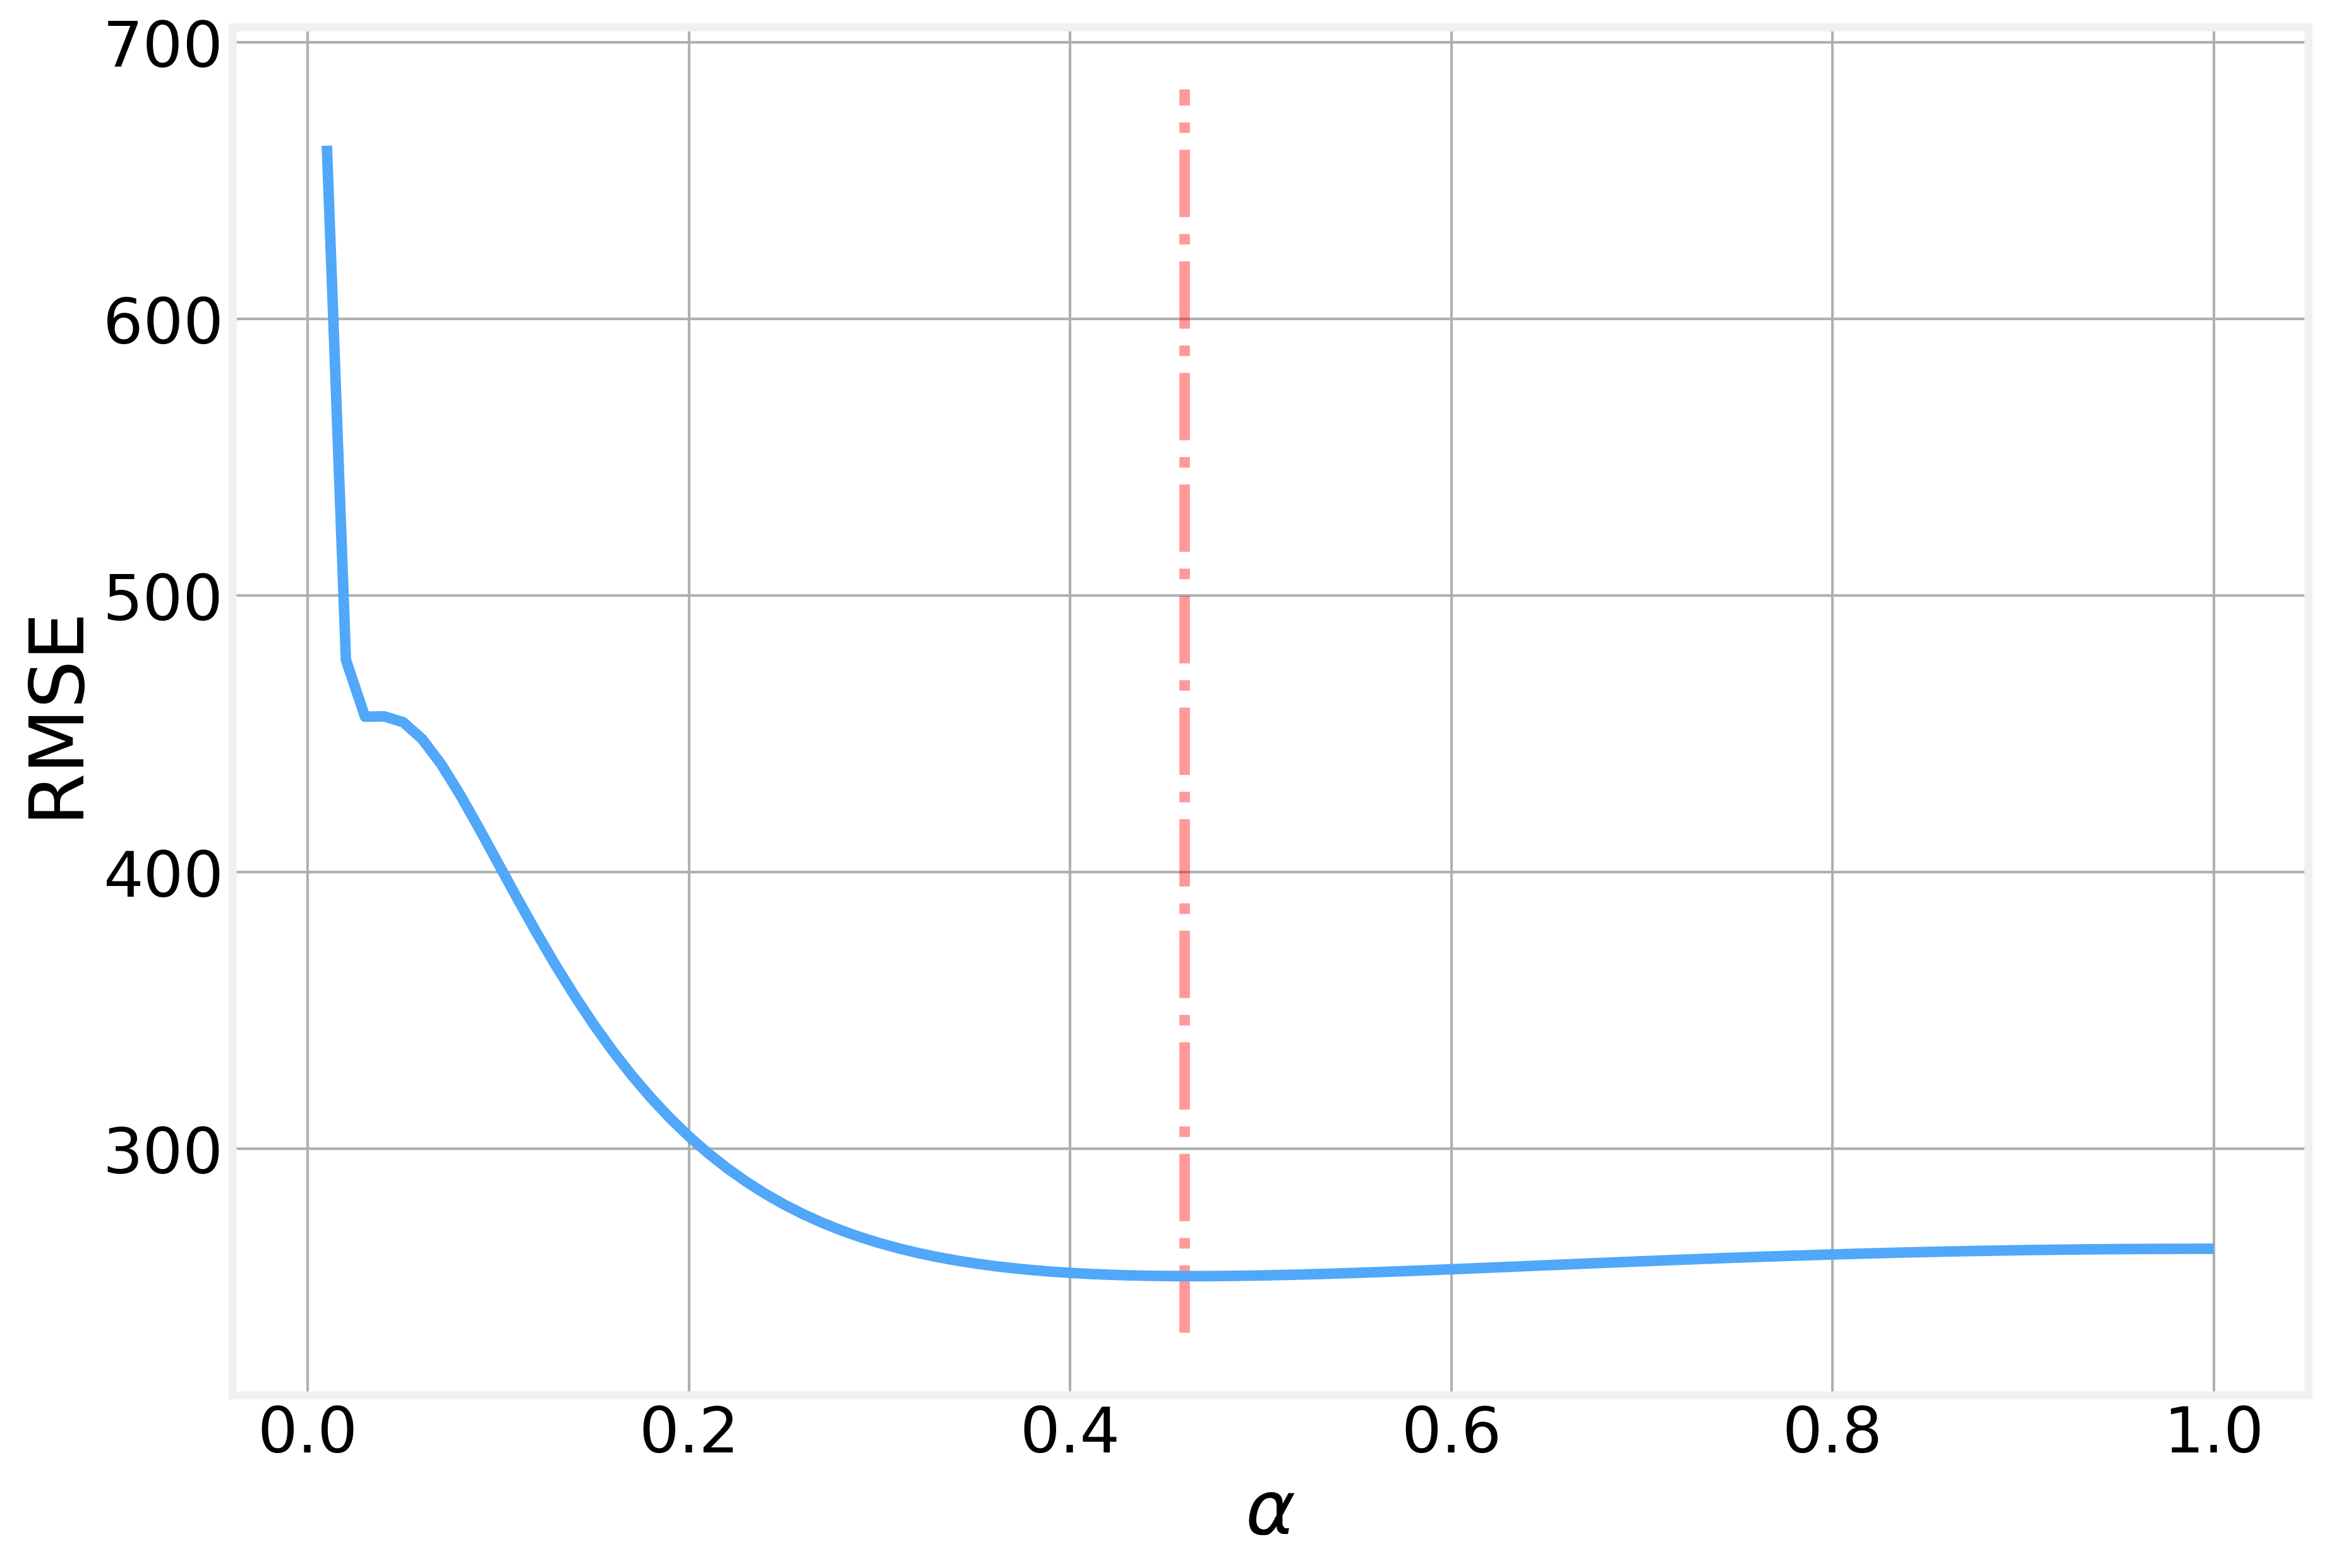

In [31]:
plt.plot(alphas, err)
ax = plt.gca()
ax.set_ylabel('RMSE')
ax.set_xlabel(r'$\alpha$')

opt_alpha = alphas[np.argmin(err)]
ax.vlines(opt_alpha, *ax.get_ylim(), linestyle='-.', colors='r', alpha=0.4)

The optimal $\alpha$ value is

In [32]:
opt_alpha

0.46

### Exercise

Load the sunspot dataset and plot the forecasts for $\alpha \in \{0.2,0.4,0.6\}$ and $N=250$

In [34]:
# %load solutions/sunspots_forecast.py

### Exercise

Calculate the optimal $\alpha$ for the sun spot dataset

In [35]:
# %load solutions/sunspots_ewma.py

### Question

Why do we get this result?

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>